# Methods for Data Science: Course Work 2

# CID: 01843211

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Task 1: Neural Networks, Dimensionality Reduction and Mixture Models (65 marks)

#### 1.1 Multi-Layer Perceptron (MLP) (25 marks)  

1.1.1

We begin by loading our data. We observe that the pixel values are 8-bit unsigned integers, which is useful for rendering, however not so useful for machine learning. We divide by $X_{train}$ by 255 to ensure values $x_i \in [0,1]$, which will make our softplus and activation derivative numerically stable for higher learning rates.

In [2]:
data1_train = pd.read_csv('MNIST_train.csv')
data1_test = pd.read_csv('MNIST_test.csv')

x1_train = data1_train.to_numpy()[:,1:] / 255
y1_train = data1_train.to_numpy()[:,0]
x1_test = data1_test.to_numpy()[:,1:] / 255
y1_test = data1_test.to_numpy()[:,0]

We will plot 10 random images from the dataset with their corresponding labels, to get a feel for what is going on.

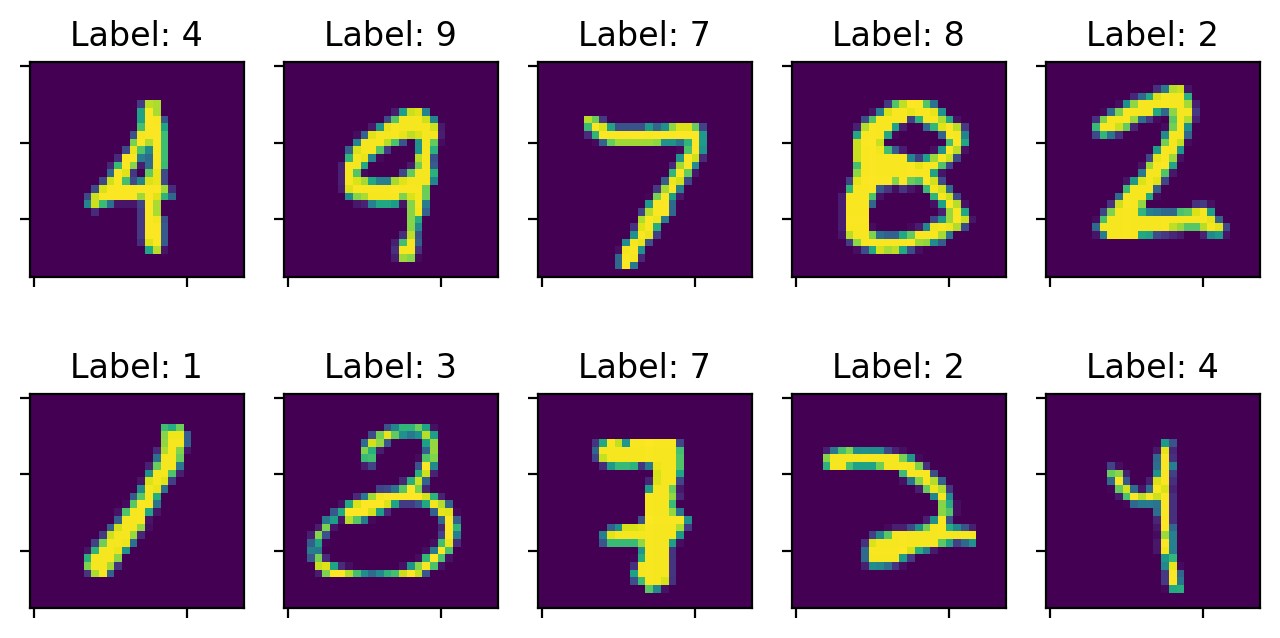

In [3]:
num = 10
images = x1_train[:num].reshape((10,28,28))
labels = y1_train[:num]

num_row = 2
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.3*num_col,1.8*num_row), dpi=200)
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i])
    ax.set_title('Label: {}'.format(labels[i]))
    ax.set_xticklabels('')
    ax.set_yticklabels('')
plt.tight_layout()
plt.show()

Immediately from this cell, we can see that some of the digits are unclear and their is variation amongst the images. 

To make our KL divergence function easier to implement, we will define one-hot encoding functions, where, for a datapoint $y_k \in {0, \dots, 9}$,

$$\text{onehot}(y) = (\delta_{y,0} \dots \delta_{y,9})$$a vector of 0s with a one in the $y$th position.

In [4]:
def onehot_1D(y):
    y_onehot = np.zeros(10)
    y_onehot[y] = 1
    return y_onehot


def onehot(y):
    result = []
    for yy in y:
        result.append(onehot_1D(yy))
    return np.array(result)

We now define `dense`, a function to output a dense layer of pre-activations with a given weights matrix $\textbf{W}$ and biases $\textbf{b}$.

In [5]:
def dense(x, W, b):
    
    # x: K x h_in array of inputs
    # W: h_in x h_out array for kernel matrix parameters
    # b: Length h_out 1-D array for bias parameters
    # returns: K x h_out output array 
    
    h = b + x @ W  ## <-- pre-activations
    return h

We now define our activation function. We will use the softplus, a smooth approximation to the rectified linear unit:$$\text{Softplus}(x)=\frac{\log (1+\exp(\beta x))}{\beta}\text{ with }\beta=1$$

In [6]:
def softplus(x, beta=1):
    return np.log(1. + np.exp(beta * x)) / beta     

We also define our softmax function:

$$\text{Softmax}(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}} \ \ \text{ for } i = 1, \dotsc, K \text{ and } \mathbf{z} = (z_1, \dotsc, z_K) \in \mathbb{R}^K$$



In [7]:
def soft(x):
    z = x - np.max(x)
    numerator = np.exp(z)
    denominator = np.sum(numerator)
    softmax = numerator/denominator
    return softmax

def stable_softmax(x):
    if x.ndim == 1:
        return soft(x)
    x1 =[]
    for i in range(x.shape[0]):
        x1.append(soft(x[i,:]))
    return np.array(x1)


Our MLP will need the following parameters:

Input layer -> first hidden layer:
* Kernel $\boldsymbol{W}^{(0)} \in\mathbb{R}^{784\times 200}$
* Bias $\boldsymbol{b}^{(0)} \in\mathbb{R}^{200}$

Hidden layer -> hidden layer:
* Kernel $\boldsymbol{W}^{(k)} \in\mathbb{R}^{200\times 200}$, $k=1, 2$
* Bias $\boldsymbol{b}^{(k)} \in\mathbb{R}^{200}$, $k=1, 2$

Hidden layer -> output layer:
* Kernel $\boldsymbol{W}^{(3)} \in\mathbb{R}^{200\times 10}$
* Bias $\boldsymbol{b}^{(3)} \in\mathbb{R}^{10}$

We will create these parameters as numpy arrays, and initialise the kernel values with samples from a zero-mean Gaussian distribution with variance $2 / (n_{in} + n_{out})$, where $n_{in}$ and $n_{out}$ are the number of neurons going in and out of the dense layer respectively. The bias parameters will be initialised to zeros.

In [8]:
# Create the parameters

var0 = 2. / (200 + 784)
W0 = np.random.randn(784, 200) * np.sqrt(var0)
b0 = np.zeros(200)

var1 = 2. / (200 + 200)
W1 = np.random.randn(200, 200) * np.sqrt(var1)
b1 = np.zeros(200)

var2 = 2. / (200 + 200)
W2 = np.random.randn(200, 200) * np.sqrt(var2)
b2 = np.zeros(200)

var3 = 2. / (10 + 200)
W3 = np.random.randn(200, 10) * np.sqrt(var3)
b3 = np.zeros(10)


We use these parameters and our `dense` function to create the MLP model. The hidden layers of the model will use a Softplus activation, and the output of the model will use a Softmax activation function.

In [9]:
def mlp(x, dropout=1):
    
    # x: K x 784 array of inputs
    # returns: K x 10 output array 
    
    h = dense(x, W0 / dropout, b0)
    h = softplus(h)
    h = dense(h, W1 / dropout, b1)
    h = softplus(h)
    h = dense(h, W2 / dropout, b2)
    h = softplus(h)
    y = dense(h, W3, b3)
    return stable_softmax(y)

The backpropagation algorithm can be summarised as follows:

>1. Define the **error** $\delta^{(k)}_p := \frac{\partial \mathcal{L}_i}{\partial a^{(k)}_p}$ for layer $k$, where we denote $\mathcal{L}_i$ as the loss for example $i$, and $a^{(k)}_p$ is the $p$-th pre-activation in layer $k$
>2. Propagate the signal forwards by passing an input vector $x_i$ through the network and computing all pre-activations and post-activations using $\mathbf{a}^{(k)} = (\boldsymbol{h}^{(k-1)})^T\boldsymbol{W}^{(k-1)} + \boldsymbol{b}^{(k-1)}$
> 3. Evaluate $\boldsymbol{\delta}^{(L+1)} = \frac{\partial \mathcal{L}_i}{\partial \boldsymbol{a}^{(L+1)}}$ for the output neurons
> 4. Backpropagate the errors to compute $\mathbf{\delta}^{(k)}$ for each hidden unit using $\boldsymbol{\delta}^{(k)} = \boldsymbol{\sigma}'(\boldsymbol{a}^{(k)})  \boldsymbol{W}^{(k)} \boldsymbol{\delta}^{(k+1)}$
> 5. Obtain the derivatives of $\mathcal{L}_i$ with respect to the weights and biases using $\frac{\partial \mathcal{L}_i}{\partial w^{(k)}_{pq}} = \delta^{(k+1)}_p h^{(k)}_q,\quad 
\frac{\partial \mathcal{L}_i}{\partial b^{(k)}_{p}} = \delta^{(k+1)}_p$

In the above, $\boldsymbol{\sigma}'(\boldsymbol{a}^{(k)})$ is a diagonal matrix with diagonal elements $\sigma'(a^{(k)}_p)$, $p=1,\ldots,n_k$, where $n_k$ is the number of neurons in hidden layer $k$.

In our case, we have an MLP with 3 hidden layers ($L=3$). The loss $\mathcal{L}_i$ will be KL-divergence: for a vector of prediction probabilities $Q=(\hat{q}_1, \dots, \hat{q}_d)$ and true distribution $P=(p_1 \dots p_d)$ the KL-divergence is given by:

$$
D_\text{KL}(P \parallel Q) = \sum_{i=1}^d p_i \log\left(\frac{p_i}{\hat{q}_i}\right)
$$

Of course, since there is only one true class, $p_i = \mathbf{1}_{y_{true}} (i)$ and so $D_\text{KL}(P \parallel Q) =-\log(\frac{1}{q_y})$.

We will start by computing the output error $\boldsymbol{\delta}^{(3)} = \frac{\partial \mathcal{L}_i}{\partial \boldsymbol{a}^{(3)}}$. With onehot encoding this is simply $\hat{y} - y_{onehot}$

1.1.2

In [10]:
def kl_divergence(y_true, y_pred):
    # Ensure that the arrays are numpy arrays and have the same shape
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
    
    # Ensure that y_true is one-hot encoded
    assert np.all(np.sum(y_true, axis=-1) == 1), "y_true must be one-hot encoded"
    y_pred = np.clip(y_pred, 1e-15,1-1e-15)
    y_true = np.clip(y_true, 1e-15,1-1e-15)
    # Compute the KL divergence
    kl_div = np.sum(y_true * np.log(y_true / y_pred), axis=-1)
    return kl_div

def output_error(y_batch, y_pred):
    
    # y_batch: K x 1 array of data outputs
    # a2: K x 10 array of output pre-activations
    # returns: K x 10 array of output errors 
    
    return y_pred - y_batch


We will also need to compute the diagonal matrix $\boldsymbol{\sigma}'(\boldsymbol{a}^{(k)})$ for $k=1,\dots,3$.

Note that $\frac{\partial}{\partial z} \log (1+e^z) = \frac{1}{1+e^{-z}}=\frac{e^z}{1+e^z}$

In [11]:
def activation_derivative(x):
    
    return np.exp(x) / (1 + np.exp(x))


1.1.3

We now build the functions with which we will train our multiayer perceptron. We need a `get_batches` function for stochastic gradient descent, and an `initialise_layers` function to re-initialise our layers each time we train.

In [12]:
def get_batches(X, y, batch_size):
    num_batches = X.shape[0] // batch_size
    batches = []
    #p = np.random.permutation(X.shape[0])
    #X = X[p]
    
    for i in range(num_batches):
        batch_start = i * batch_size
        batch_end = (i + 1) * batch_size
        batchX = X[batch_start:batch_end]
        batchY = y[batch_start:batch_end]
        batches.append((batchX, batchY))
        
    if X.shape[0] % batch_size != 0:
        batch_start = num_batches * batch_size
        batchX = X[batch_start:]
        batchY = y[batch_start:]
        batches.append((batchX, batchY))
    
    return batches

def initialise_layers(hidden_width=200):
    var0 = 2. / (hidden_width + 784)
    W0 = np.random.randn(784, hidden_width) * np.sqrt(var0)
    b0 = np.ones(hidden_width)
    
    var1 = 2. / (hidden_width + hidden_width)
    W1 = np.random.randn(hidden_width, hidden_width) * np.sqrt(var1)
    b1 = np.ones(hidden_width)
    
    var2 = 2. / (hidden_width + hidden_width)
    W2 = np.random.randn(hidden_width, hidden_width) * np.sqrt(var2)
    b2 = np.ones(hidden_width)
    
    var3 = 2. / (10 + hidden_width)
    W3 = np.random.randn(hidden_width, 10) * np.sqrt(var3)
    b3 = np.ones(10)
    
    return W0, b0, W1, b1, W2, b2, W3, b3

Now we are ready to train our first MLP. We will examine learning rates between $10^{-4}$ and $10^{-1}$.

In [13]:
import time
start_time = time.time()

learning_rates = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
batch_size = 128
losses = dict(keys=learning_rates)

for learning_rate in learning_rates:

    W0, b0, W1, b1, W2, b2, W3, b3 = initialise_layers()
    loss_current = []
    print (f"Training for learning rate {learning_rate}")
    for i in range(40):

        batch_losses = []
        for data in get_batches(x1_train, y1_train, batch_size):
            X, y = data[0], data[1]

            # Forward pass
            z1 = dense(X, W0, b0)
            a1 = softplus(z1)
        
            z2 = dense(a1, W1, b1)
            a2 = softplus(z2)
        
            z3 = dense(a2, W2, b2)
            a3 = softplus(z3)
        
            z4 = dense(a3, W3, b3)
            output = stable_softmax(z4)
        
            # Backpropagation
            batch_losses.append(np.average(kl_divergence(onehot(y), output)))
            error = output_error(onehot(y), output)

            d_weights3 = np.dot(a3.T, error) / batch_size
            d_bias3 = np.sum(error, axis=0, keepdims=True) / batch_size
        
            d_a3 = np.dot(error, W3.T)
            d_z3 = d_a3 * activation_derivative(z3)
            d_weights2 = np.dot(a2.T, d_z3) / batch_size
            d_bias2 = np.sum(d_z3, axis=0, keepdims=True) / batch_size

            d_a2 = np.dot(d_z3, W2.T)
            d_z2 = d_a2 * activation_derivative(z2)
            d_weights1 = np.dot(a1.T, d_z2) / batch_size
            d_bias1 = np.sum(d_z2, axis=0, keepdims=True) / batch_size

            d_a1 = np.dot(d_z2, W1.T)
            d_z1 = d_a1 * activation_derivative(z1)
            d_weights0 = np.dot(X.T, d_z1) / batch_size
            d_bias0 = np.sum(d_z1, axis=0, keepdims=True) / batch_size
    
            # Update weights and biases
            W0 -= learning_rate * d_weights0
            b0 -= learning_rate * d_bias0.reshape(200,)
            W1 -= learning_rate * d_weights1
            b1 -= learning_rate * d_bias1.reshape(200,)
            W2 -= learning_rate * d_weights2
            b2 -= learning_rate * d_bias2.reshape(200,)
            W3 -= learning_rate * d_weights3
            b3 -= learning_rate * d_bias3.reshape(10,)
            
        loss_current.append(np.mean(batch_losses))
    losses[learning_rate] = loss_current
    print ("training done")
%store losses    
print("--- Finished in %s seconds ---" % (time.time() - start_time))

Training for learning rate 0.0005
training done
Training for learning rate 0.001
training done
Training for learning rate 0.005
training done
Training for learning rate 0.01
training done
Training for learning rate 0.05
training done
Training for learning rate 0.1
training done
Stored 'losses' (dict)
--- Finished in 128.07881712913513 seconds ---


In [14]:
preds11 = mlp(x1_test)
acctest = 0
for i, row in enumerate(preds11):
    acctest += np.argmax(row) == y1_test[i]
acctest /= len(y1_test)

preds12 = mlp(x1_train)
acctrain = 0
for i, row in enumerate(preds12):
    acctrain += np.argmax(row) == y1_train[i]
acctrain /= len(y1_train)

print(f"train accuracy={acctrain:.4f} for learning rate={learning_rates[-1]}")
print(f"test accuracy={acctest:.4f} for learning rate={learning_rates[-1]}")

train accuracy=0.9643 for learning rate=0.1
test accuracy=0.9310 for learning rate=0.1


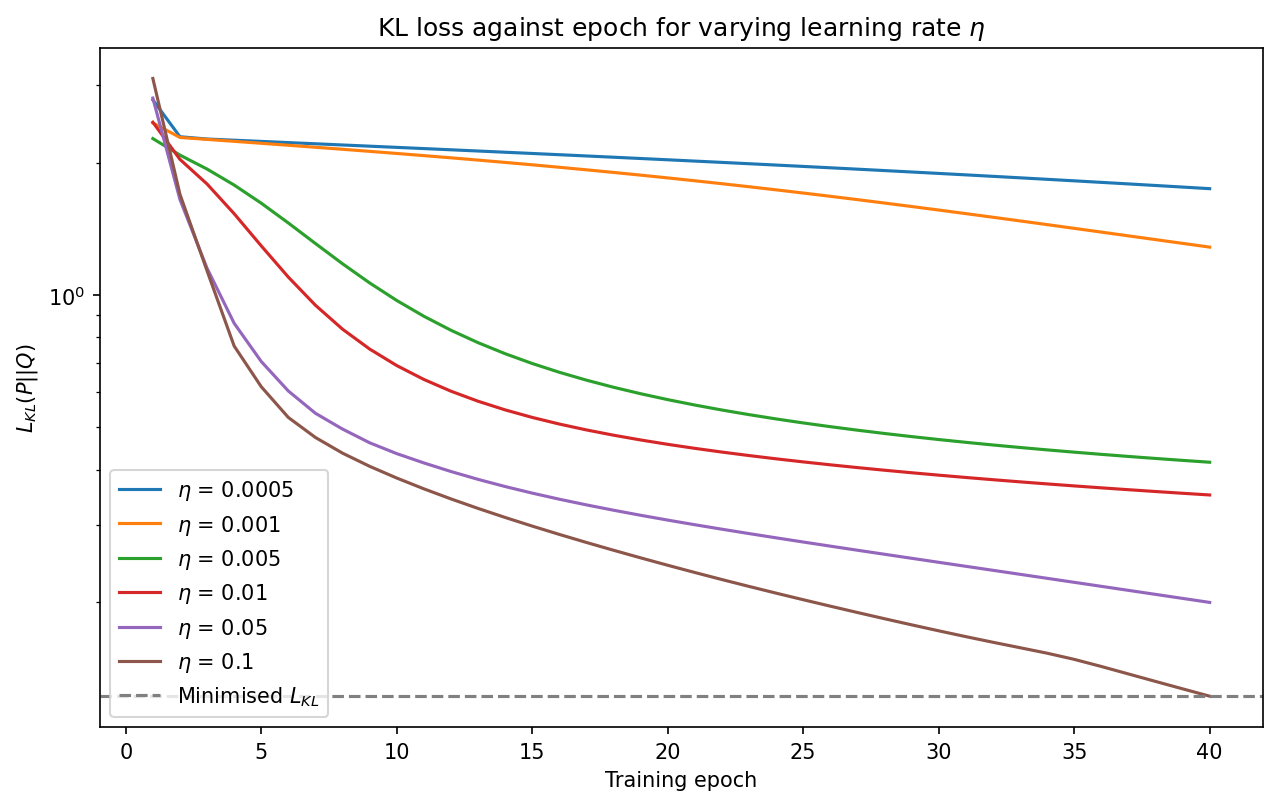

In [15]:
plt.figure(figsize=(10,6), dpi=150)
plt.yscale("log")
for i, lam in enumerate(learning_rates):
    plt.plot(range(1,41),losses[lam], label=f"$\eta$ = {lam}")
plt.title(r"KL loss against epoch for varying learning rate $\eta$")
plt.xlabel("Training epoch")
plt.ylabel("$L_{KL}(P||Q)$")
plt.axhline(np.min(losses[learning_rates[-1]]), linestyle="--", color="gray", label="Minimised $L_{KL}$")
plt.legend()
plt.show()



The fastest to converge, as expected, is the highest learning rate $\eta=0.1$ Ideally, we would use a learning rate higher than this, however the softplus function and its derivative are very sensitive to larger numbers, resulting in overflow.

We set the optimal learning rate and proceed to evaluate the accuracy and KL loss on both the training and tst set over 40 epochs.

In [16]:
start_time = time.time()

learning_rate = 0.1
W0, b0, W1, b1, W2, b2, W3, b3 = initialise_layers()
losses = {"train":[], "test":[]}
accuracies = {"train":[], "test":[]}

for i in np.arange(40):
    batch_losses = []
    for data in get_batches(x1_train, y1_train, batch_size):
        
        X, y = data[0], data[1]
        
        # Forward propagation
        z1 = dense(X, W0, b0)
        a1 = softplus(z1)
        
        z2 = dense(a1, W1, b1)
        a2 = softplus(z2)
        
        z3 = dense(a2, W2, b2)
        a3 = softplus(z3)
        
        z4 = dense(a3, W3, b3)
        output = stable_softmax(z4)
        
        # Backward propagation
        
        error = output_error(onehot(y), output)
        #delta4 = output_error(onehot(y1_train), h4)

        d_weights3 = np.dot(a3.T, error) / batch_size
        d_bias3 = np.sum(error, axis=0, keepdims=True) / batch_size
        #delta3 = backpropagate(delta4, W3, a3)

        
        d_a3 = np.dot(error, W3.T)
        d_z3 = d_a3 * activation_derivative(z3)
        d_weights2 = np.dot(a2.T, d_z3) / batch_size
        d_bias2 = np.sum(d_z3, axis=0, keepdims=True) / batch_size
        #delta2 = backpropagate(delta3, W2, a2)
        
        d_a2 = np.dot(d_z3, W2.T)
        d_z2 = d_a2 * activation_derivative(z2)
        d_weights1 = np.dot(a1.T, d_z2) / batch_size
        d_bias1 = np.sum(d_z2, axis=0, keepdims=True) / batch_size
        #delta1 = backpropagate(delta2, W1, a1)
        
        d_a1 = np.dot(d_z2, W1.T)
        d_z1 = d_a1 * activation_derivative(z1)
        d_weights0 = np.dot(X.T, d_z1) / batch_size
        d_bias0 = np.sum(d_z1, axis=0, keepdims=True) / batch_size
    
        # Update weights and biases
        W0 -= learning_rate * d_weights0
        b0 -= learning_rate * d_bias0.reshape(200,)
        W1 -= learning_rate * d_weights1
        b1 -= learning_rate * d_bias1.reshape(200,)
        W2 -= learning_rate * d_weights2
        b2 -= learning_rate * d_bias2.reshape(200,)
        W3 -= learning_rate * d_weights3
        b3 -= learning_rate * d_bias3.reshape(10,)
    
    preds11 = mlp(x1_test)
    acctest = 0
    for i, row in enumerate(preds11):
        acctest += np.argmax(row) == y1_test[i]
    acctest /= len(y1_test)
    accuracies["test"].append(acctest)
    losses["test"].append(np.average(kl_divergence(onehot(y1_test), preds11)))
    
    preds12 = mlp(x1_train)
    acctrain = 0
    for i, row in enumerate(preds12):
        acctrain += np.argmax(row) == y1_train[i]
    acctrain /= len(y1_train)
    accuracies["train"].append(acctrain)
    losses["train"].append(np.average(kl_divergence(onehot(y1_train), preds12)))

print("--- Finished in %s seconds ---" % (time.time() - start_time))

--- Finished in 40.340243101119995 seconds ---


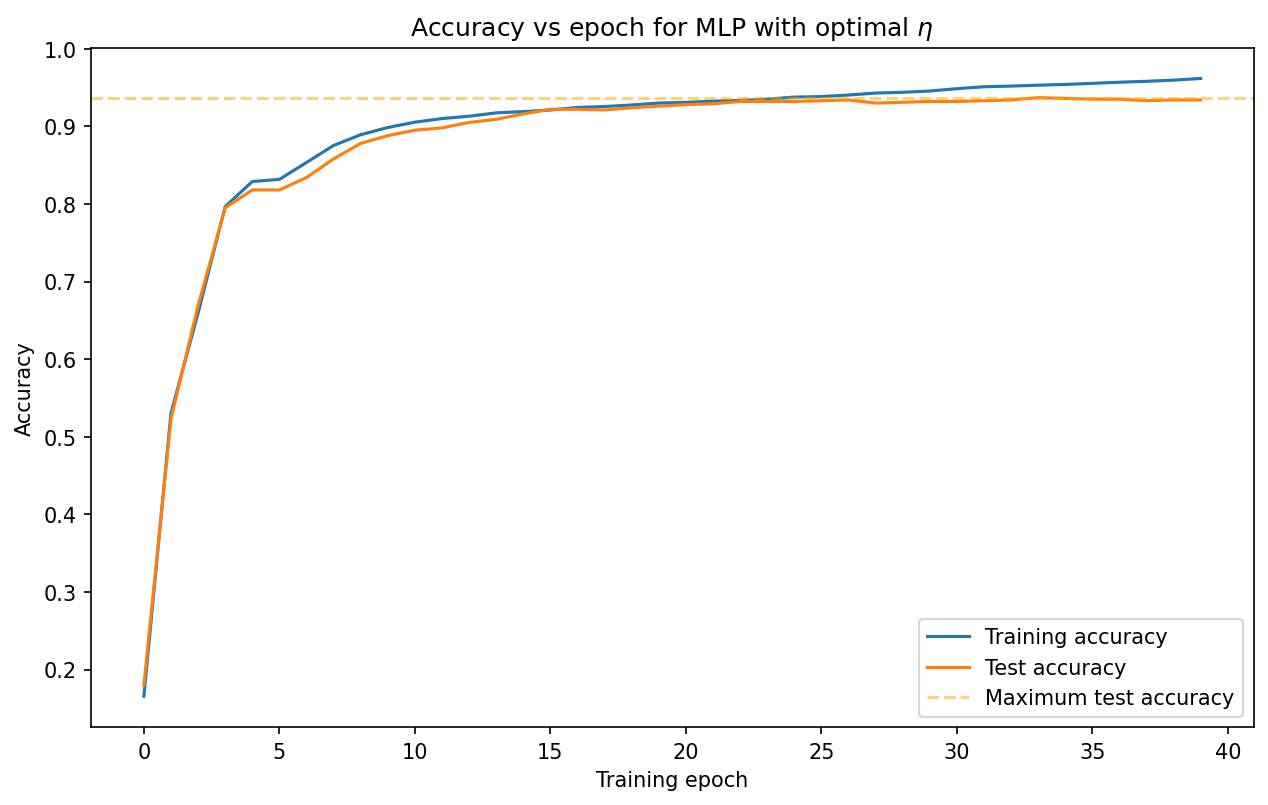

In [17]:
plt.figure(figsize=(10,6), dpi=150)
plt.plot(accuracies["train"], label="Training accuracy")
plt.plot(accuracies["test"], label="Test accuracy")
plt.axhline(np.max(accuracies["test"]), color='orange', label="Maximum test accuracy", linestyle="--", alpha=0.5)
plt.title(r"Accuracy vs epoch for MLP with optimal $\eta$")
plt.legend()
plt.xlabel("Training epoch")
plt.ylabel("Accuracy")
plt.show()

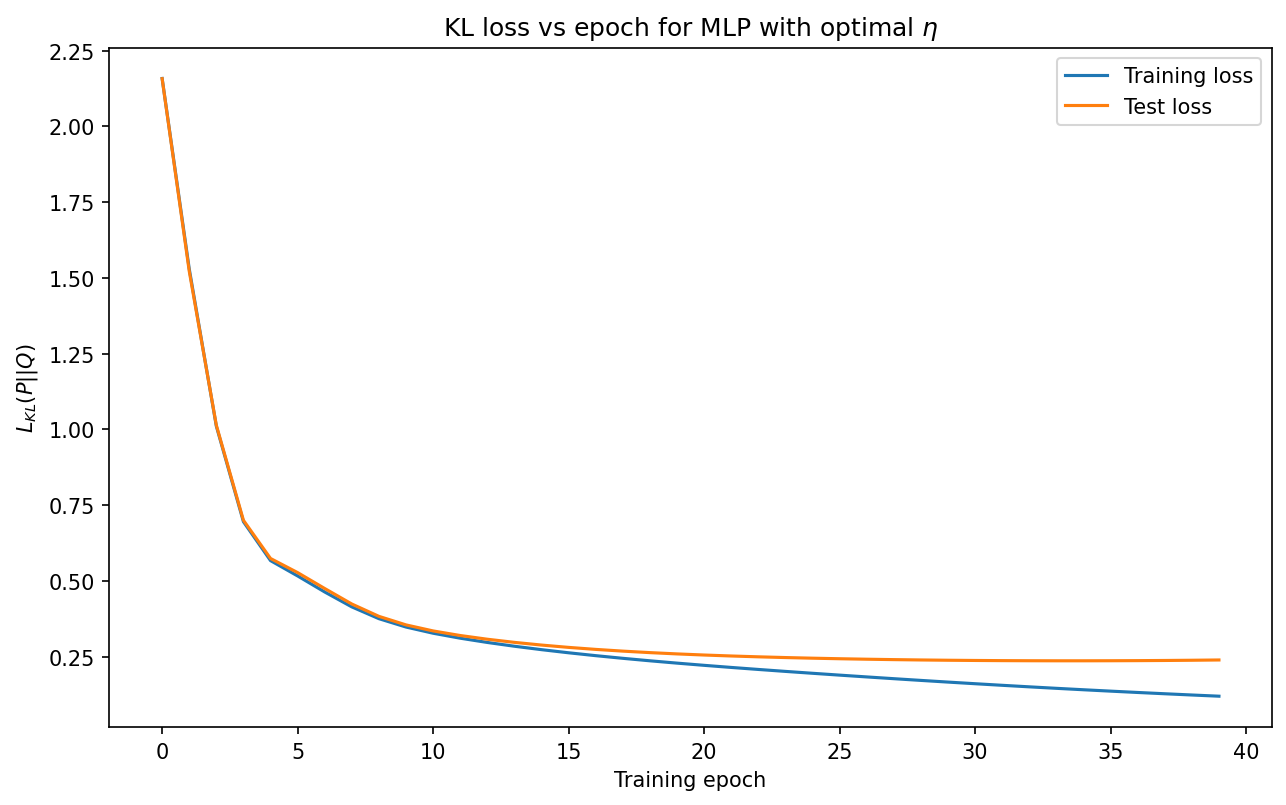

In [18]:
plt.figure(figsize=(10,6), dpi=150)
plt.plot(losses["train"], label="Training loss")
plt.plot(losses["test"], label="Test loss")
plt.title(r"KL loss vs epoch for MLP with optimal $\eta$")
plt.legend()
plt.xlabel("Training epoch")
plt.ylabel("$L_{KL}(P||Q)$")
plt.show()

We see that at the optimal learning rate, the accuracy and the loss initially quickly optimise for both test and train. However, after around 20 epochs, the training set loss continues to decrease, but the test set loss actually <b>increases</b> (and accuracy decreases). This is evidence that our model is overfitting.

We now reduce the number of neurons in each hidden layer and evaluate the model's performance over time.

In [21]:
#New layers so we don't overrwrite optimal
hidden_width = 50
W01, b01, W11, b11, W21, b21, W31, b31 = initialise_layers(hidden_width=hidden_width)

#New mlp funciton
def mlpreduced(x):
    """Predicts MLP with weights, biases and reduced layer parasms"""
    # x: K x 784 array of inputs
    # returns: K x 10 output array 
    
    h = dense(x, W01, b01)
    h = softplus(h)
    h = dense(h, W11, b11)
    h = softplus(h)
    h = dense(h, W21, b21)
    h = softplus(h)
    y = dense(h, W31, b31)
    return stable_softmax(y)

start_time = time.time()

learning_rate = 0.1



losses113 = {"train":[], "test":[]}
accuracies113 = {"train":[], "test":[]}

for i in np.arange(40):
    batch_losses = []
    for data in get_batches(x1_train, y1_train, batch_size):
        
        X, y = data[0], data[1]
        
        # Forward propagation
        z1 = dense(X, W01, b11)
        a1 = softplus(z1)
        
        z2 = dense(a1, W11, b11)
        a2 = softplus(z2)
        
        z3 = dense(a2, W21, b21)
        a3 = softplus(z3)
        
        z4 = dense(a3, W31, b31)
        output = stable_softmax(z4)
        
        # Backward propagation
        error = output_error(onehot(y), output)

        d_weights3 = np.dot(a3.T, error) / batch_size
        d_bias3 = np.sum(error, axis=0, keepdims=True) / batch_size

        d_a3 = np.dot(error, W31.T)
        d_z3 = d_a3 * activation_derivative(z3)
        d_weights2 = np.dot(a2.T, d_z3) / batch_size
        d_bias2 = np.sum(d_z3, axis=0, keepdims=True) / batch_size

        d_a2 = np.dot(d_z3, W21.T)
        d_z2 = d_a2 * activation_derivative(z2)
        d_weights1 = np.dot(a1.T, d_z2) / batch_size
        d_bias1 = np.sum(d_z2, axis=0, keepdims=True) / batch_size

        d_a1 = np.dot(d_z2, W11.T)
        d_z1 = d_a1 * activation_derivative(z1)
        d_weights0 = np.dot(X.T, d_z1) / batch_size
        d_bias0 = np.sum(d_z1, axis=0, keepdims=True) / batch_size
    
        # Update weights and biases
        W01 -= learning_rate * d_weights0
        b01 -= learning_rate * d_bias0.reshape(hidden_width,)
        W11 -= learning_rate * d_weights1
        b11 -= learning_rate * d_bias1.reshape(hidden_width,)
        W21 -= learning_rate * d_weights2
        b21 -= learning_rate * d_bias2.reshape(hidden_width,)
        W31 -= learning_rate * d_weights3
        b31 -= learning_rate * d_bias3.reshape(10,)
    
    preds11 = mlpreduced(x1_test)
    acctest = 0
    for i, row in enumerate(preds11):
        acctest += np.argmax(row) == y1_test[i]
    acctest /= len(y1_test)
    accuracies113["test"].append(acctest)
    losses113["test"].append(np.average(kl_divergence(onehot(y1_test), preds11)))
    
    preds12 = mlpreduced(x1_train)
    acctrain = 0
    for i, row in enumerate(preds12):
        acctrain += np.argmax(row) == y1_train[i]
    acctrain /= len(y1_train)
    accuracies113["train"].append(acctrain)
    losses113["train"].append(np.average(kl_divergence(onehot(y1_train), preds12)))
    
print("--- Finished in %s seconds ---" % (time.time() - start_time))

--- Finished in 16.283022165298462 seconds ---


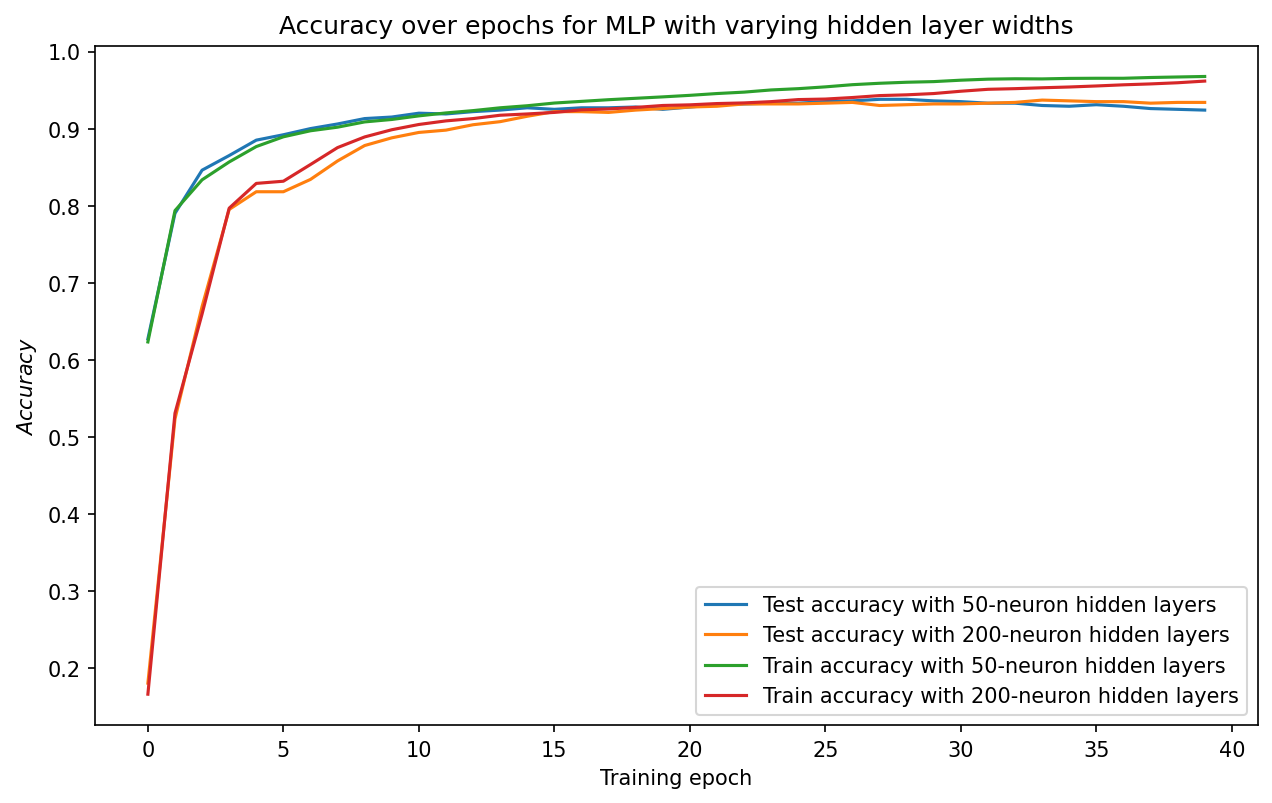

In [22]:
plt.figure(figsize=(10,6), dpi=150)
plt.plot(accuracies113["test"], label="Test accuracy with 50-neuron hidden layers")
plt.plot(accuracies["test"], label="Test accuracy with 200-neuron hidden layers")
plt.plot(accuracies113["train"], label="Train accuracy with 50-neuron hidden layers")
plt.plot(accuracies["train"], label="Train accuracy with 200-neuron hidden layers")
plt.title(r"Accuracy over epochs for MLP with varying hidden layer widths")
plt.legend()
plt.xlabel("Training epoch")
plt.ylabel("$Accuracy$")
plt.show()

We see an interesting pattern here: the 50-neuron MLP learns the training set much quicker. The training accuracy is higher initially and remains higher throughout training than that of the original 200-neuron MLP. However, the test accuracy remains consitently lower, indicating higher generalization error. This is again indicative of the fact that the 50-neuron MLP is overfitted to the training set.

We will now implement a dropout to increase sparsity of the network and reduce overfitting.

1.1.4

In [23]:
def dropout(n, p):
    """Returns a. iid Bernoulli sample vector with probability p of being 1"""
    vec = np.random.binomial(size=n, n=1, p=p)
    return np.diag(vec)

start_time = time.time()

learning_rate = 0.1
hidden_width = 200
dropout_rate = 0.8
W0dropout, b0dropout, W1dropout, b1dropout, W2dropout, b2dropout, W3dropout, b3dropout = initialise_layers(hidden_width=hidden_width)

def mlpdropout(x, dropout=0.8):
    """Predicts MLP with weights, biases and specified dropout"""
    # x: K x 784 array of inputs
    # returns: K x 10 output array 
    
    h = dense(x, W0dropout, b0dropout)
    h = softplus(h) / dropout
    h = dense(h, W1dropout, b1dropout)
    h = softplus(h) / dropout
    h = dense(h, W2dropout, b2dropout)
    h = softplus(h) / dropout
    y = dense(h, W3dropout, b3dropout)
    return stable_softmax(y)

losses114 = {"train":[], "test":[]}
accuracies114 = {"train":[], "test":[]}

for i in np.arange(150):
    batch_losses = []
    #print(f"epoch {i}")
    for data in get_batches(x1_train, y1_train, batch_size):
        
        X, y = data[0], data[1]
        
        # Forward propagation
        drop1 = dropout(hidden_width, dropout_rate)
        z1 = dense(X, W0dropout, b0dropout)
        a1 = softplus(z1) @ drop1 / dropout_rate
        #print(a1[0,:])
        
        drop2 = dropout(hidden_width, dropout_rate)
        z2 = dense(a1, W1dropout, b1dropout) 
        a2 = softplus(z2) @ drop2 / dropout_rate 
        
        drop3 = dropout(hidden_width, dropout_rate)
        z3 = dense(a2, W2dropout, b2dropout)
        a3 = softplus(z3) @ drop3 / dropout_rate
        
        z4 = dense(a3, W3dropout, b3dropout)
        output = stable_softmax(z4)
        
        # Backward propagation
        
        error = output_error(onehot(y), output)
        #delta4 = output_error(onehot(y1_train), h4)

        d_weights3 = np.dot(a3.T, error) / batch_size
        d_bias3 = np.sum(error, axis=0, keepdims=True) / batch_size
        #delta3 = backpropagate(delta4, W3dropout, a3)

        
        d_a3 = np.dot(error, W3dropout.T) @ drop3 / dropout_rate
        d_z3 = d_a3 * activation_derivative(z3)
        d_weights2 = np.dot(a2.T, d_z3) / batch_size
        d_bias2 = np.sum(d_z3, axis=0, keepdims=True) / batch_size
        #delta2 = backpropagate(delta3, W2dropout, a2)
        
        d_a2 = np.dot(d_z3, W2dropout.T) @ drop2 / dropout_rate
        d_z2 = d_a2 * activation_derivative(z2)
        d_weights1 = np.dot(a1.T, d_z2) / batch_size
        d_bias1 = np.sum(d_z2, axis=0, keepdims=True) / batch_size
        #delta1 = backpropagate(delta2, W1dropout, a1)
        
        d_a1 = np.dot(d_z2, W1dropout.T) @ drop1 / dropout_rate
        d_z1 = d_a1 * activation_derivative(z1)
        d_weights0 = np.dot(X.T, d_z1) / batch_size
        d_bias0 = np.sum(d_z1, axis=0, keepdims=True) / batch_size
    
        # Update weights and biases
        W0dropout -= learning_rate * d_weights0
        b0dropout -= learning_rate * d_bias0.reshape(hidden_width,)
        W1dropout -= learning_rate * d_weights1
        b1dropout -= learning_rate * d_bias1.reshape(hidden_width,)
        W2dropout -= learning_rate * d_weights2
        b2dropout -= learning_rate * d_bias2.reshape(hidden_width,)
        W3dropout -= learning_rate * d_weights3
        b3dropout -= learning_rate * d_bias3.reshape(10,)
    
    preds11 = mlpdropout(x1_test, dropout=1)
    acctest = 0
    for i, row in enumerate(preds11):
        acctest += np.argmax(row) == y1_test[i]
    acctest /= len(y1_test)
    accuracies114["test"].append(acctest)
    losses114["test"].append(np.average(kl_divergence(onehot(y1_test), preds11)))
    
    preds12 = mlpdropout(x1_train, dropout=dropout_rate)
    acctrain = 0
    for i, row in enumerate(preds12):
        acctrain += np.argmax(row) == y1_train[i]
    acctrain /= len(y1_train)
    accuracies114["train"].append(acctrain)
    losses114["train"].append(np.average(kl_divergence(onehot(y1_train), preds12)))
    
print("--- Finished in %s seconds ---" % (time.time() - start_time))

--- Finished in 169.52549576759338 seconds ---


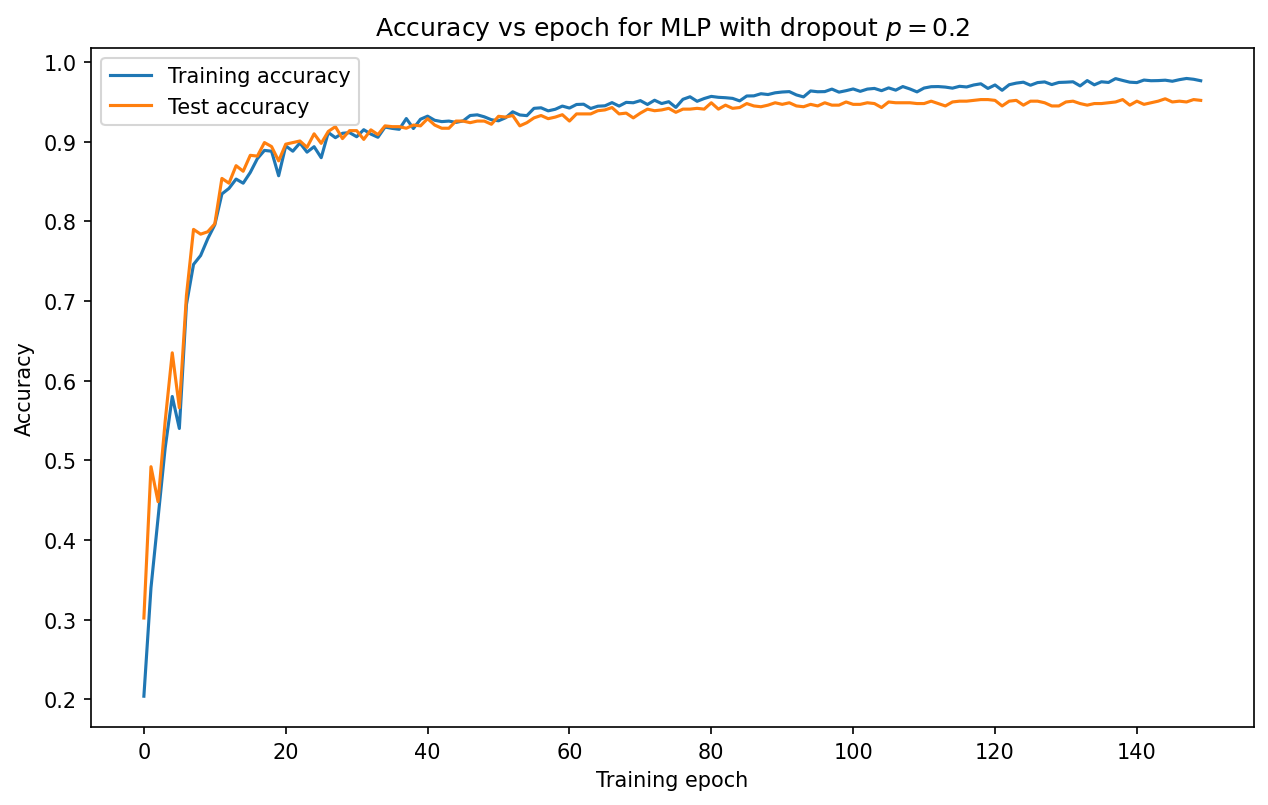

In [24]:
plt.figure(figsize=(10,6), dpi=150)
plt.plot(accuracies114["train"], label="Training accuracy")
plt.plot(accuracies114["test"], label="Test accuracy")
plt.title(r"Accuracy vs epoch for MLP with dropout $p=0.2$")
plt.legend()
plt.xlabel("Training epoch")
plt.ylabel("Accuracy")
plt.show()

In [25]:
print (f"final test accuracy: {accuracies114['test'][-2]}")

final test accuracy: 0.953


As we can see, the final accuracy is marginally higher than the original MLP. The test accuracy continues to increase beyond 20 epochs, suggesting the sparsity of the network prevents overfitting. 

In [26]:
data114 = get_batches(x1_train, y1_train, 3000)
X114, y114 = data114[0][0], data114[1][0]
activations114 = dense(X114, W0dropout, b0dropout)
activations114 = softplus(activations114)
meanactivations114 = np.mean(activations114, axis=0)

activations114_1 = dense(X114, W0, b0)
activations114_1 = softplus(activations114_1)
meanactivations114_1 = np.mean(activations114_1, axis=0)

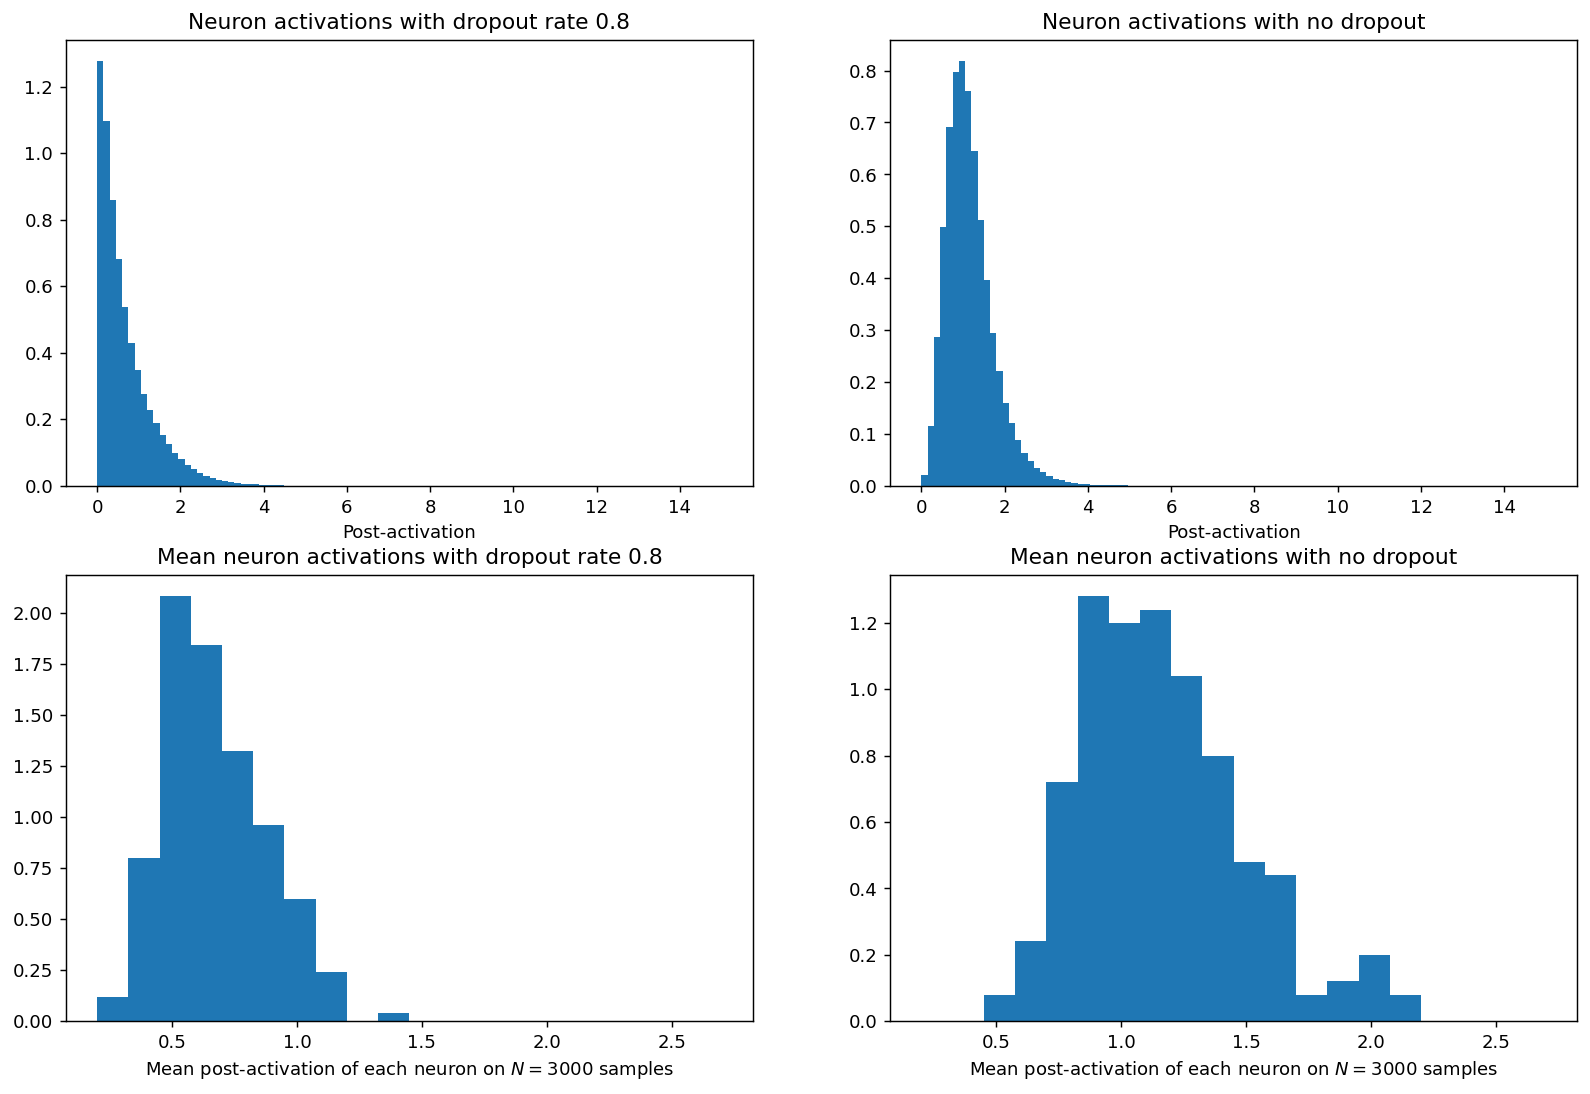

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(15,10), dpi=130)
axs[0, 0].hist(activations114.flatten(), bins=100, range=(0,15), density=True)
axs[0, 0].set_title("Neuron activations with dropout rate 0.8")
axs[0, 0].set_xlabel("Post-activation")
#axs[0,0].set_ylim([0, 80000])
axs[0, 1].hist(activations114_1.flatten(), bins=100, range=(0,15), density=True)
axs[0, 1].set_title("Neuron activations with no dropout")
axs[0, 1].set_xlabel("Post-activation")
#axs[0, 1].set_ylim([0,80000])
axs[1, 0].hist(meanactivations114, bins=20, range=(0.2, 2.7), density=True)
axs[1, 0].set_title("Mean neuron activations with dropout rate 0.8")
axs[1, 0].set_xlabel("Mean post-activation of each neuron on $N=3000$ samples")
axs[1, 1].hist(meanactivations114_1, bins=20, range=(0.2, 2.7), density=True)
axs[1, 1].set_title("Mean neuron activations with no dropout")
axs[1, 1].set_xlabel("Mean post-activation of each neuron on $N=3000$ samples")

plt.show()

The activations are much more sparse with dropout. Many more units have activation close to 0, with a clear mode at 0, in contrast to no dropout, where the mode and mean is higher than 1. The mean activation of each neuron is generally lower with dropout as well. This reflects the fact that individual neurons are forced to take on more responsibility for detecting features like lines, curves and shapes.

In [28]:
plt.figure(figsize=(10,6), dpi=3100)
plt.plot(accuracies["test"], color="b", label = "Test accuracy with no dropout", alpha=0.5)
plt.plot([40,149], [accuracies["test"][39]]*2, linestyle="--", color="b", alpha=0.5)
plt.plot(accuracies114["train"], label="Dropout training accuracy")
plt.plot(accuracies114["test"], label="Dropout test accuracy")

plt.title(r"Accuracy with/without dropout")
plt.legend()
plt.xlabel("Training epoch")
plt.ylabel("Accuracy")
plt.show()

We can see that initially, the network with no dropout makes much more gains than the one with dropout, as the test accuracy peaks out very quickly, and then actually begins to decrease. I have extrapolated the accuracy after 40 epochs to emphasise that, whilst the network with dropout takes a while to converge, it does in fact overtake the one with no dropout, resulting in a better test accuracy. In fact, as opposed to the no-dropout MLP, which begins to predict the test set with lower accuracy after a certain number of epochs, the MLP with dropout is robust to overfitting.

This is to be expected, as the goal of dropout is to reduce the generalisation error.

#### 1.2 Dimensionality reduction (20 marks)

1.2.1

We now consider a noisy version of the dataset. We will load the data and examine the first few images.

In [30]:
import numpy as np
import pandas as pd

data12_train = pd.read_csv('MNIST_train_noise.txt', header=None, delim_whitespace=True)
data12_test = pd.read_csv('MNIST_test_noise.txt', header=None, delim_whitespace=True)

data12_train.head()

0         1          2          3        4         5         6    \
0  14.6928  41.54430   0.650907   1.840060 -13.7111   2.70121   6.83062   
1  15.3966   3.48577  -9.859870   0.118088 -20.4242   7.05606  -7.52257   
2 -11.0810 -26.95600  35.461200  17.933200  27.0783  10.06230  -1.39500   
3 -14.0739   8.25860 -19.878500 -34.264400  17.9438   2.41847 -20.42540   
4 -17.5225  -8.16958   3.151930  -0.275071 -35.8109  20.09230  22.93350   

        7          8        9    ...        774        775       776  \
0   2.09018  13.268500 -18.1447  ...   0.258495   2.873340 -25.03930   
1 -10.05210  36.961100  15.2378  ... -49.228200  -0.718321  -8.45148   
2  -9.70152  -0.209274 -25.9756  ...  25.887800  -3.327740  -8.33229   
3  61.76750  -9.236050  28.4589  ...  19.365200   1.560740 -13.91450   
4   7.17066  -2.912430  27.5866  ... -18.768500  14.614500 -23.66130   

        777       778        779       780      781      782        783  
0   1.99615  16.16070  -5.719610  50.55980  21.3238 -12.2810 -14.281200  
1  11.21700  11.39290 -45.847100  15.66640 -23.1307 -11.7599  23.594000  
2  -9.38559  -2.29055 -15.951000 -17.68880  37.2149 -39.6784   1.759430  
3 -40.45090   7.99698  11.741300   2.23981  37.5290  36.7471  -0.942664  
4   9.91770 -17.43010  -0.103124  10.03820 -29.4632  21.2691 -14.285800  

[5 rows x 784 columns]

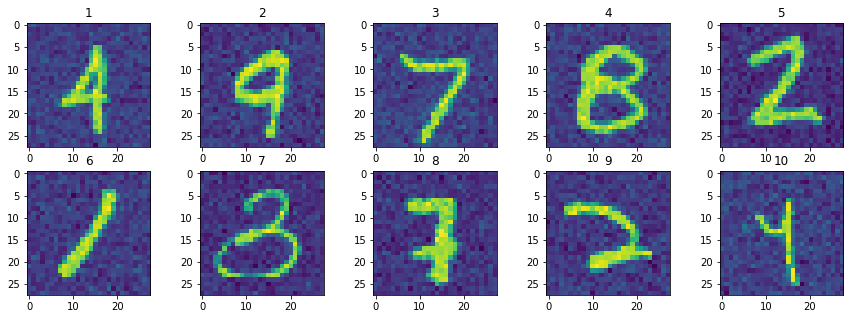

In [31]:
nrow = 2; ncol = 5;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(15,5))

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(data12_train.to_numpy()[i,:].reshape([28,28]))
    ax.set_title(str(i + 1))

We aim to implement PCA. To do this we need to train on standardised data, which has been standardised with $\mu_{train}$ and $\sigma_{train}$. We also define an unstandardise function, to return our images to their original scale.

In [32]:
x12_train = data12_train.to_numpy()
x12_test = data12_test.to_numpy()

def standardise(X, X_train):
    mu = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

def unstandardise(X, X_train):
    mu = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    std_filled = std.copy()
    #std_filled[std==0] = 1.
    Xorig = mu + std_filled * X
    return Xorig

x12_test_standardised = standardise(x12_test, x12_train)
x12_train_standardised = standardise(x12_train, x12_train)

We now build the standard PCA function, taking $X$ as an input and sorting the eigenvalues from high to low, returning the $k$ highest with their corresponding eigenvectors, which are our principal components.

In [33]:
from scipy.sparse import linalg

def pca_function(X, k):

    # create covariance matrix C
    C = 1.0/(len(X)-1) * np.dot(X.T, X) ## <-- SOLUTION

    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, k, which="LM", return_eigenvectors=True) 

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:,sorted_index ]

    # transform our data
    X_pca = X.dot(eigenvectors) ## <-- SOLUTION

    return X_pca, eigenvectors, eigenvalues

We will now visualise the eigenvalues of the noisy data:

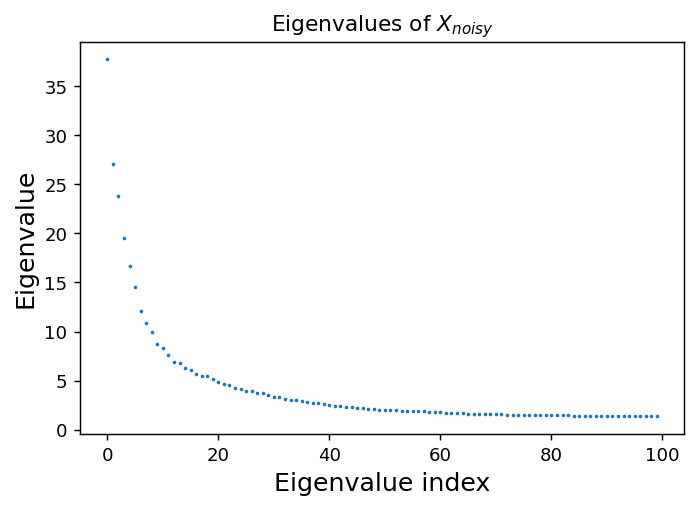

In [34]:
k=100
# compute the projection, the eigenvector and eigenvalues from our function
X_pca, eigenvectors, eigenvalues = pca_function(x12_train_standardised,k) 

plt.figure(dpi=130)
plt.scatter(range(len(eigenvalues)), eigenvalues, s=1)
plt.title("Eigenvalues of $X_{noisy}$")
plt.xlabel('Eigenvalue index',fontsize=14)
plt.ylabel('Eigenvalue',fontsize=14)
plt.show()

It does not appear that there is a clear cut off which would provide the number of principal components. We will therefore calculate how ma ny eigenvectors are required to explain 70%, 80% and 90% of the variance respectively.

In [35]:
k=783
X_pca, eigenvectors, eigenvalues = pca_function(x12_train_standardised,k) 

C = 1.0/(len(x12_train_standardised)-1) * np.dot(x12_train_standardised.T, x12_train_standardised)
all_eigenvalues, _ = np.linalg.eig(C)
total_variance = abs(all_eigenvalues.sum())

explained_variances = eigenvalues /  total_variance ## <-- SOLUTION
cumsum_121 = np.cumsum(explained_variances)
var07 = np.where(cumsum_121 > 0.7)[0][0]
var08 = np.where(cumsum_121 > 0.8)[0][0]
var09 = np.where(cumsum_121 > 0.9)[0][0]
print (f"70% of the variance is explained at m = {var07 + 1}")
print (f"80% of the variance is explained at m = {var08 + 1}")
print (f"90% of the variance is explained at m = {var09 + 1}")

70% of the variance is explained at m = 213
80% of the variance is explained at m = 298
90% of the variance is explained at m = 408


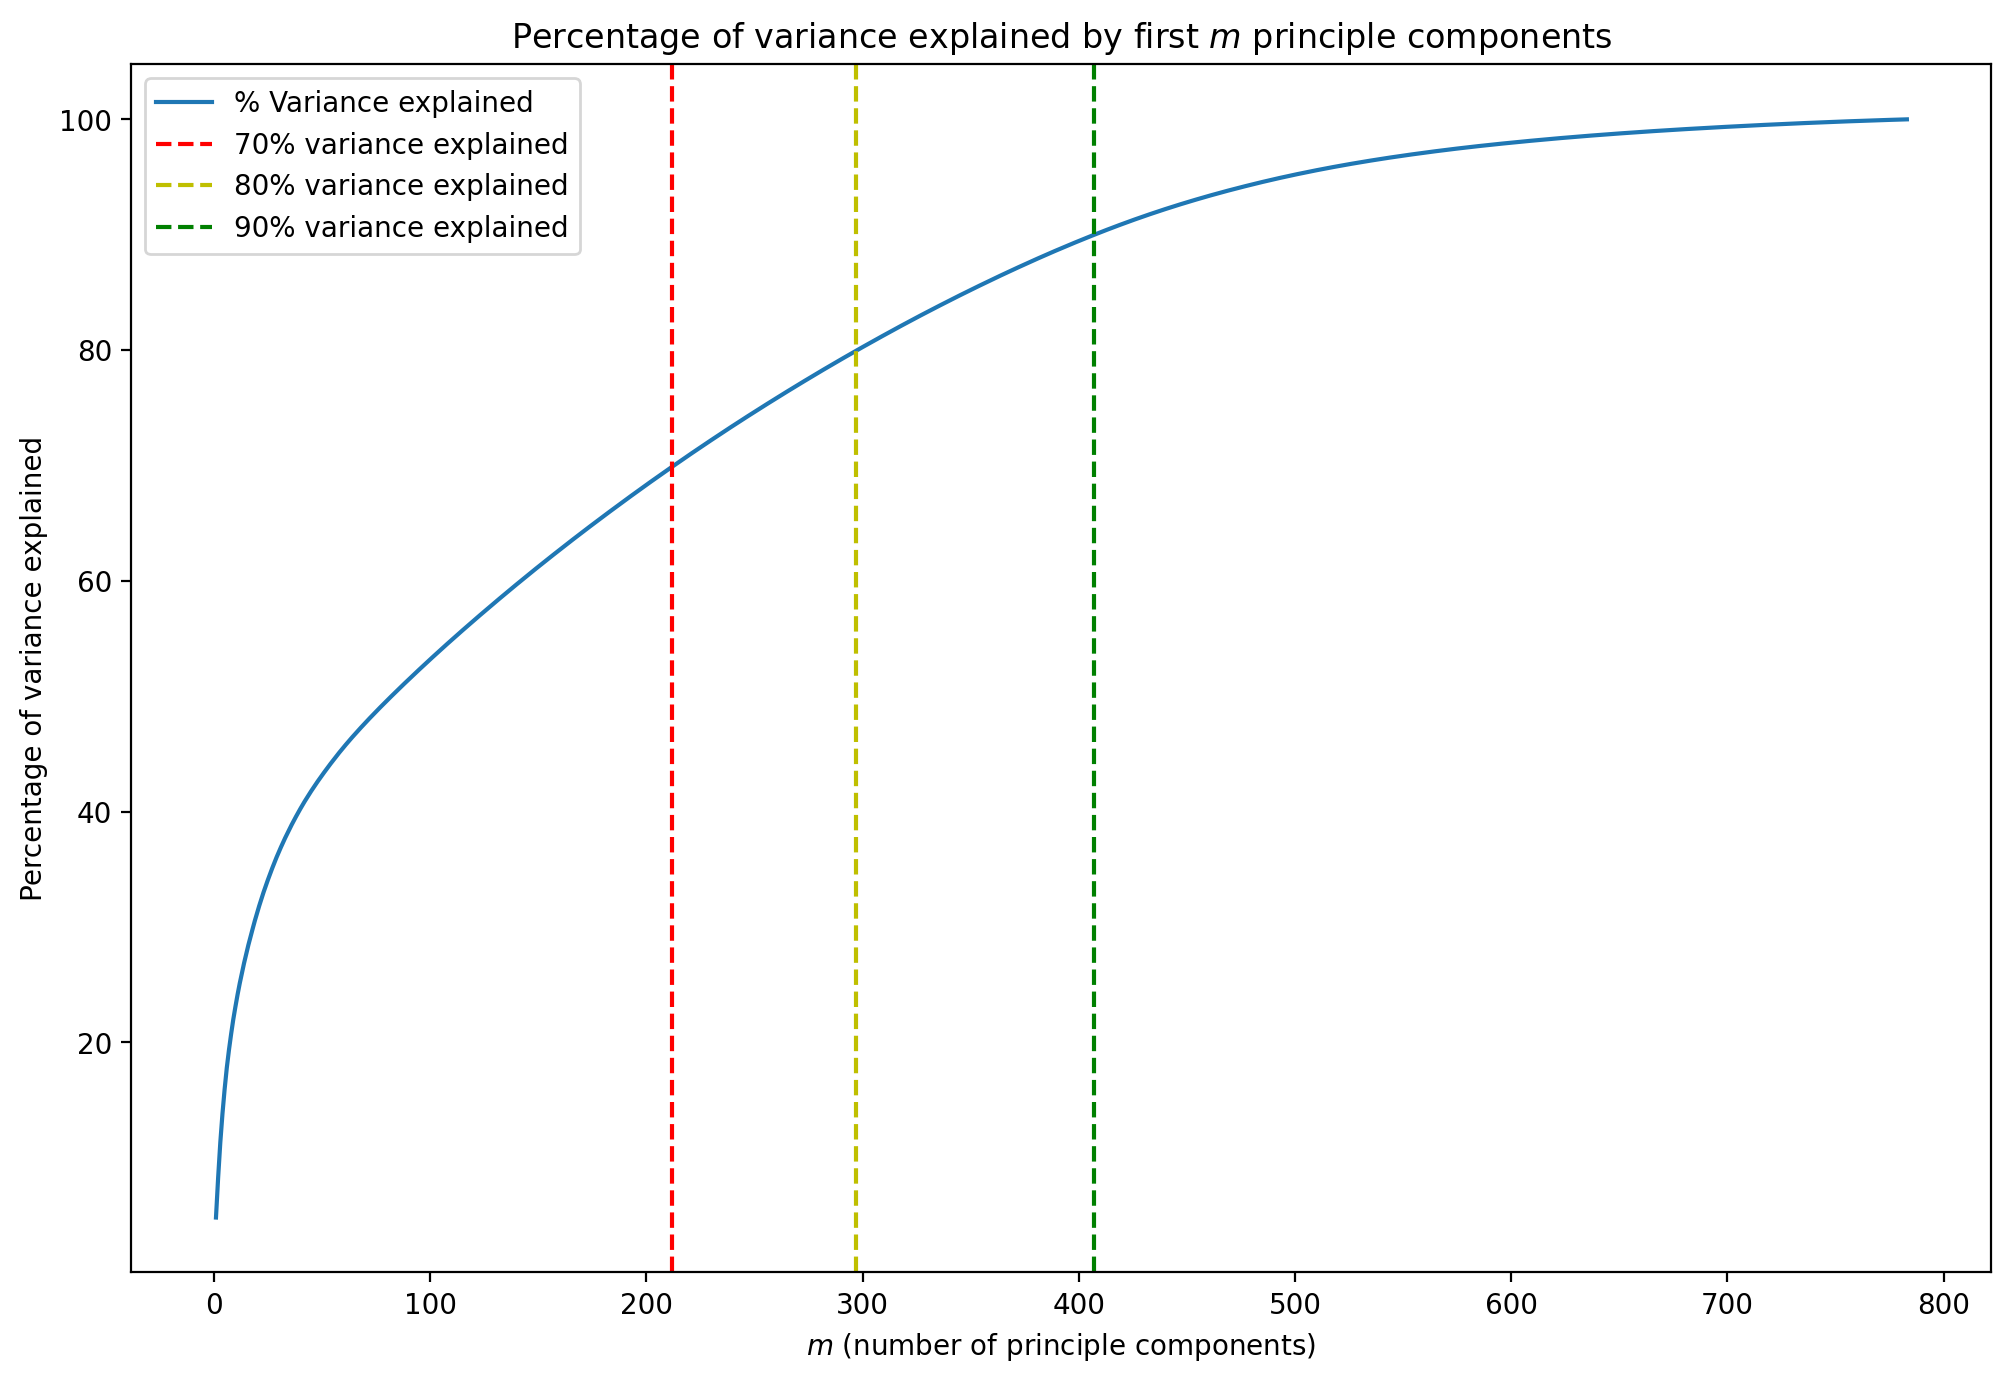

In [36]:

plt.figure(figsize=(12,8), dpi=200)
plt.title("Percentage of variance explained by first $m$ principle components")
plt.plot(np.arange(1, 784), cumsum_121 * 100, label="% Variance explained")
plt.xlabel("$m$ (number of principle components)")
plt.ylabel("Percentage of variance explained")
plt.axvline(var07, color="r", linestyle="--", label="70% variance explained")
plt.axvline(var08, color="y", linestyle="--", label="80% variance explained")
plt.axvline(var09, color="g", linestyle="--", label="90% variance explained")
plt.legend()
plt.show()

The graph does appear to grow less steeply at around $m=100$, suggesting this would be a good number for dimensionality reduction. We will visualise the first 10 principle components to indentify any patterns.

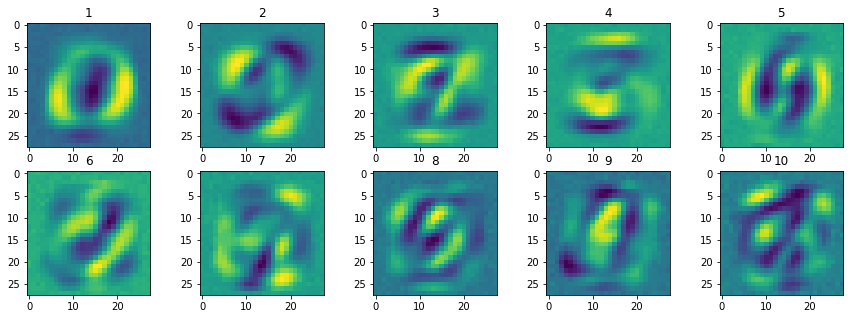

In [37]:
k = 10
X_pca, eigenvectors, eigenvalues = pca_function(x12_train_standardised,k) ## <-- SOLUTION

nrow = 2; ncol = 5;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(15,5))

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(eigenvectors[:,i].reshape([28,28]))
    ax.set_title(str(i + 1))

There are traces of some shapes visible: the first principle component is reminiscent of a zero, and others seem to have picked up on some features of other numbers.

1.2.3
We will now implement non-negative matrix factorisation. We define our min-max normalizer, and the corresponding inverse, in order to proceed with the algorithm, as we require inputs between 0 and 1.

NMF factors our n-by-m feature matrix $\mathbf X$ into nonnegative factors $\mathbf W$ (n-by-k) and $\mathbf H$ (k-by-m). The factorization is not exact. $\mathbf W\mathbf H$ is a lower-rank approximation to $\mathbf A$. The factors $\mathbf W$ and $\mathbf H$ minimize the root mean square residual D between $\mathbf X$ and $\mathbf W\mathbf H$.

Here we will use Lee and Seung's multiplicative update rule. 

<center>
$
\mathbf{H}_{[i,j]}^{n+1}\leftarrow \mathbf{H}_{[i,j]}^{n} 
\frac{(( \mathbf{W}^n)^T \mathbf{X})_{[i,j]}}{((\mathbf{W}^n)^T \mathbf{W}^n \mathbf{H}^n)_{[i,j]}}
$
</center>

and

<center>
$
\mathbf{W}_{[i,j]}^{n+1}\leftarrow \mathbf{W}_{[i,j]}^{n} 
\frac{(\mathbf{X}(\mathbf{H}^{n+1})^T)_{[i,j]}}{(\mathbf{W}^n \mathbf{H}^{n+1} (\mathbf{H}^{n+1})^T)_{[i,j]}}
$
</center>

until $\mathbf{W}$ and $\mathbf{H}$ are stable.

In [38]:
def normalize_nmf(X, X_train):
    X_norm = (X- np.min(X_train)) / (np.max(X_train) - np.min(X_train)) ## <-- SOLUTION
    return X_norm

def unnormalize_nmf(X, X_train):
    X_unnorm = X * (np.max(X_train) - np.min(X_train)) + np.min(X_train)
    return X_unnorm

In [39]:
x122_train = (data12_train.to_numpy().reshape(-1, 28 * 28)) / 255.
x122_test = (data12_test.to_numpy().reshape(-1, 28 * 28)) / 255.

x122_train = normalize_nmf(x122_train, x122_train)
x122_test = normalize_nmf(x122_test, x122_train)

We define the cost function
<center>
$
||X - WH||^2 = \sum_{ij}(X_{ij} - (WH)_{ij})^2
$
</center>

and proceed with our training until the changes in the norms of each matrix have settled down.

In [40]:
def cost(X,W,H):
  
    # compute the difference between X and the dot product of W and H
    diff = X - np.dot(W, H) ## <-- SOLUTION
    
    # Compute the Euclidean distance-based objective function
    cost_value = (diff * diff).sum() / (X.shape[0]*X.shape[1]) ## <-- SOLUTION
    
    # Here we have also normalized the sum by the nummber of terms in the sum (but it's not necessary).
    
    return cost_value

In [41]:
k = 10

# setting the random seed (just so everyone gets the same results...)
np.random.seed(6)

# k x P matrix interpreted as the basis set, where k is the number of components, P the number of descriptors of the data
H122 = np.random.rand(k, x122_train.shape[1])

# N x k components matrix, usually interpreted as the coefficients, N is the number of data
W122 = np.random.rand(x122_train.shape[0], k)

# set the number of iterations
n_iters = 500
pseudo_count = 0.001 ## this is just a small value that we place at the denominator to avoid division by zero

# empty list 
cost_values = []

# loop over the n iterations
for i in np.arange(n_iters):
    
    oldH = H122
    lsuH = ((W122.T.dot(x122_train))/(W122.T.dot(W122.dot(H122))+pseudo_count))
    H122 = oldH * lsuH ## <-- SOLUTION
    
    oldW = W122
    lsuW = ((x122_train.dot(H122.T))/(W122.dot(H122.dot(H122.T))+pseudo_count))
    W122 = W122 * lsuW ## <-- SOLUTION
    
    
    if i % 50 == 0:
        print (f"||deltaH||: {np.linalg.norm(H122-oldH)}, ||deltaW||: {np.linalg.norm(W122-oldW)}")
        
    # compute the cost and append to list
    cost_values.append(cost(x122_train,W122,H122))

||deltaH||: 45.70338273798946, ||deltaW||: 29.100719950105074
||deltaH||: 0.0898559072447562, ||deltaW||: 2.1702108674403022
||deltaH||: 0.021484705034166284, ||deltaW||: 0.47188595921311355
||deltaH||: 0.01123675054734202, ||deltaW||: 0.23888590311512514
||deltaH||: 0.007938089596927567, ||deltaW||: 0.16153240028330523
||deltaH||: 0.006376700316352217, ||deltaW||: 0.12697880352840143
||deltaH||: 0.005618566542583902, ||deltaW||: 0.10997567377461259
||deltaH||: 0.005086568070457162, ||deltaW||: 0.09846032765426281
||deltaH||: 0.004589736362392403, ||deltaW||: 0.08758117016989776
||deltaH||: 0.004180379656312736, ||deltaW||: 0.07839875084771644


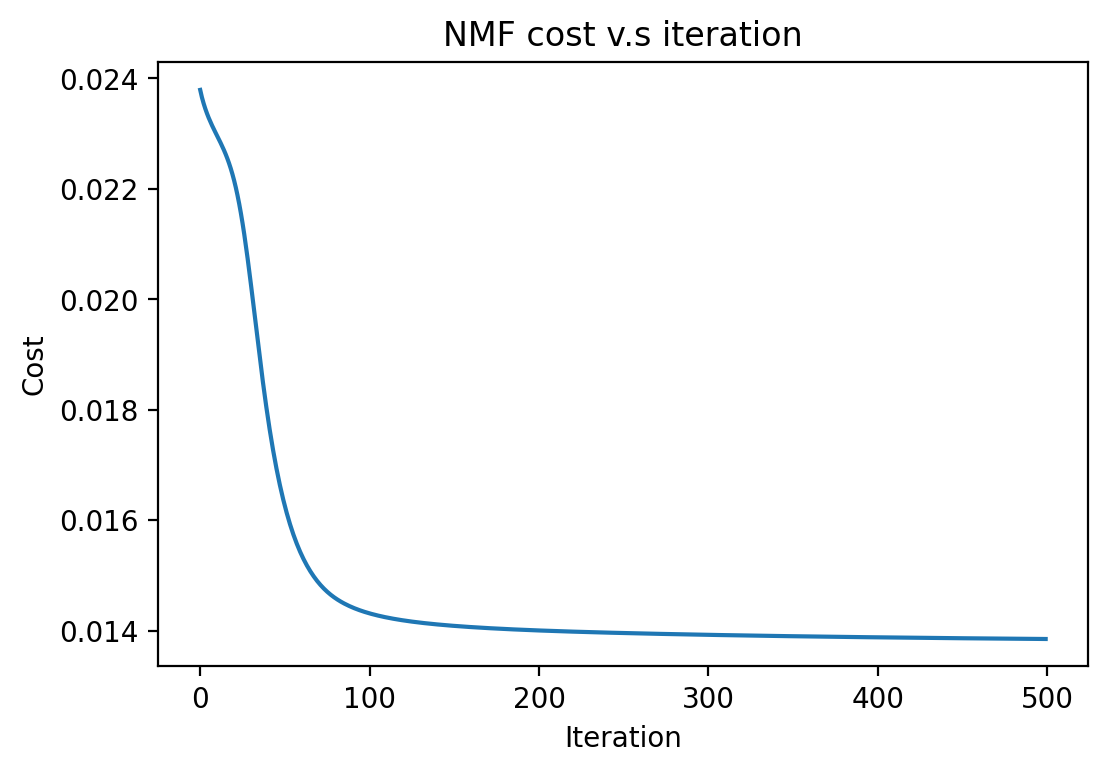

In [42]:
plt.figure(dpi=200)
plt.title("NMF cost v.s iteration")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.plot(cost_values)
plt.show()

From this graph, it is clear that we have converged, as the improvement in the cost function is marginal after this number of iterations, so we take $\mathbf{W}$ and $\mathbf{H}$ to be our factorisation.

We will now visualise the first 10 components of the NMF, which are the rows of $\mathbf{H}$.

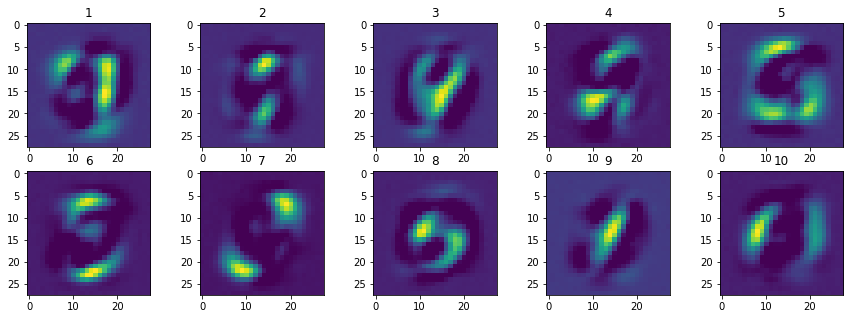

In [43]:
nrow = 2; ncol = 5;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(15,5))

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(H122[i,:].reshape([28,28]))
    ax.set_title(str(i + 1))

These components look rather different to those we had with PCA. Why is this?

PCA is based on finding the directions of maximal variance in the data and projecting the data onto a lower-dimensional subspace spanned by these directions. In contrast, NMF seeks to factorize a non-negative matrix into two non-negative matrices, where the columns of the factor matrices correspond to the basis vectors of the data.

The key difference between PCA and NMF is that PCA components can be positive or negative, whereas NMF components are always non-negative. This is because PCA is based on the eigenvalue decomposition of the covariance matrix of the data, which can have both positive and negative eigenvalues. In contrast, NMF enforces non-negativity constraints on the factor matrices, which leads to non-negative components. This is why the components we see above have a narrower range.

Another difference is that PCA components are orthogonal to each other, whereas NMF components are not necessarily orthogonal. This is because PCA seeks to find the directions of maximal variance that are uncorrelated with each other, whereas NMF does not impose such constraints on the basis vectors.

As a result of these differences, the components obtained by PCA and NMF can differ. PCA may be more suitable for capturing global patterns in the data, whereas NMF may be more suitable for capturing local patterns and parts-based representations. We saw with the PCA components much larger 'shapes', whereas NMF gives smaller details.

1.2.4

We now train 100 NMF components, and compare the results of denoising from NMF and PCA:

In [44]:
k = 100

# setting the random seed
np.random.seed(6)

# k x P matrix interpreted as the basis set, where k is the number of components, P the number of descriptors of the data
H123 = np.random.rand(k, x122_train.shape[1])

# N x k components matrix, usually interpreted as the coefficients, N is the number of data
W123 = np.random.rand(x122_train.shape[0], k)

# set the number of iterations
n_iters = 1000
pseudo_count = 0.001 ## this is just a small value that we place at the denominator to avoid division by zero

# empty list 
cost_values = []

# loop over the n iterations
for i in np.arange(n_iters):
    
    oldH = H123
    lsuH = ((W123.T.dot(x122_train))/(W123.T.dot(W123.dot(H123))+pseudo_count))
    H123 = oldH * lsuH ## <-- SOLUTION
    
    oldW = W123
    lsuW = ((x122_train.dot(H123.T))/(W123.dot(H123.dot(H123.T))+pseudo_count))
    W123 = W123 * lsuW ## <-- SOLUTION
    
    
    if i % 50 == 0:
        print (f"||deltaH||: {np.linalg.norm(H123-oldH)}, ||deltaW||: {np.linalg.norm(W123-oldW)}")
        
    # compute the cost and append to list
    cost_values.append(cost(x122_train,W123,H123))

||deltaH||: 159.14501075235677, ||deltaW||: 49.771870773613024
||deltaH||: 0.05461795147595565, ||deltaW||: 10.126969507250953
||deltaH||: 0.02336489647515631, ||deltaW||: 4.139250589514052
||deltaH||: 0.015283147060821383, ||deltaW||: 2.346044279678529
||deltaH||: 0.012130391774043976, ||deltaW||: 1.6059314882054472
||deltaH||: 0.010358052784973206, ||deltaW||: 1.207793165131366
||deltaH||: 0.009205468457346716, ||deltaW||: 0.965594835668135
||deltaH||: 0.008402787692309751, ||deltaW||: 0.8035530941894328
||deltaH||: 0.007846064815214103, ||deltaW||: 0.6932636581209373
||deltaH||: 0.007474175981675754, ||deltaW||: 0.6120824117427508
||deltaH||: 0.007168350050713356, ||deltaW||: 0.5474719687693543
||deltaH||: 0.006938489409565672, ||deltaW||: 0.49789703864169815
||deltaH||: 0.006769321177891158, ||deltaW||: 0.45728642738503483
||deltaH||: 0.006600711663601846, ||deltaW||: 0.420443557795605
||deltaH||: 0.006432287607473096, ||deltaW||: 0.38856570080329106
||deltaH||: 0.00626888611457162

In PCA, our basis vectors for the eigenspace are the columns of `eigenvectors`, and in NMF the basis vectors are the columns of `H`. To project onto the subspace for our reduced rank approximation, we use $X B B^T$ where $B$ is the corresponding basis, and unstandardise/unnormalize as required

In [45]:
k = 100
X_pca, eigenvectors, eigenvalues = pca_function(x12_train_standardised,k)

x12_test_pca = unstandardise(x12_test @ eigenvectors @ eigenvectors.T, x12_train)
x12_test_nmf = unnormalize_nmf(np.dot(x12_test, H123.T) @ H123, x12_train)

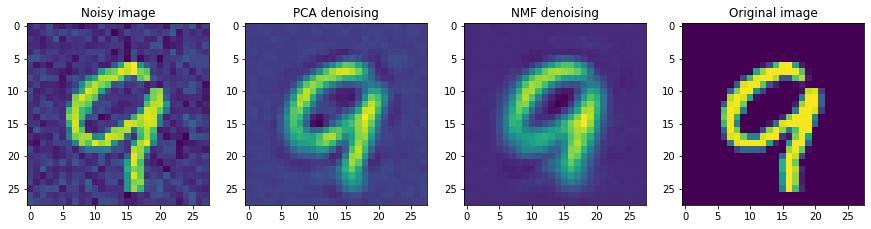

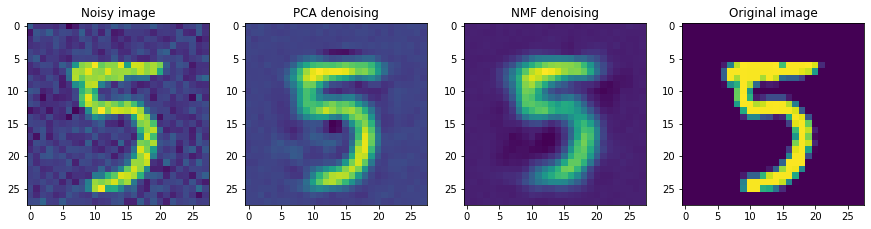

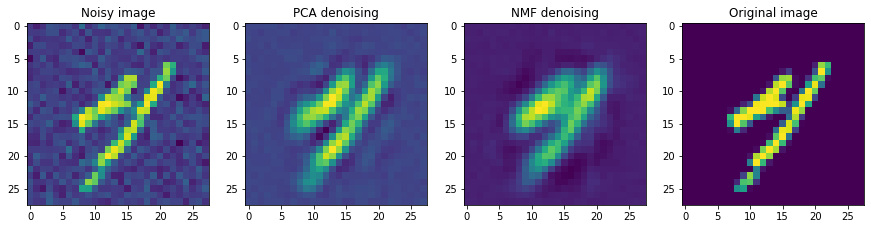

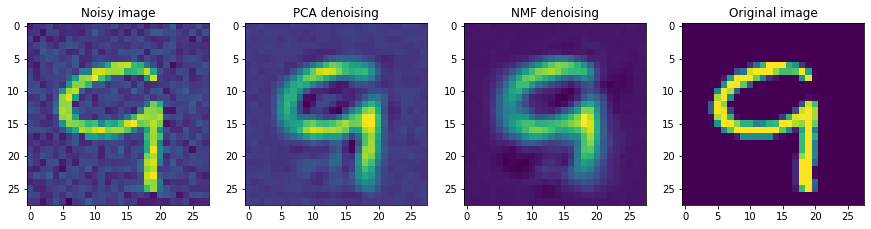

In [46]:
np.random.seed(69)

range122 = np.random.randint(x1_test.shape[0], size=4)

for k in range122:
    nrow = 1; ncol = 4;
    fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(15,5))

    output123 = [(x12_test[k, :], "Noisy image"), (x12_test_pca[k, :], "PCA denoising"), (x12_test_nmf[k,:], "NMF denoising"), (x1_test[k,:], "Original image")]
    for i,ax in enumerate(axs.reshape(-1)):
        ax.imshow(normalize_nmf(output123[i % 4][0], output123[i % 4][0]).reshape([28,28]))
        ax.set_title(output123[i % 4][1])

The NMF denoising at first glance seems slightly better than PCA. In the case of denoising MNIST noisy data, NMF may be better than PCA because it is able to model the non-negative structure of the data and may be more robust to noise and outliers. This is because NMF seeks to factorize a non-negative matrix into two non-negative matrices, where the columns of the factor matrices correspond to the basis vectors of the data.

In contrast, PCA does not take into account the non-negative structure of the data and may be sensitive to noise and outliers. PCA seeks to find the directions of maximal variance in the data and projects the data onto a lower-dimensional subspace spanned by these directions. This can result in the loss of information and may not be suitable for denoising tasks.

By contrast, NMF can decompose the noisy data into non-negative basis vectors and non-negative coefficients, which can be used to reconstruct the denoised data. This allows NMF to better preserve the non-negative structure of the data and may lead to better denoising performance.

Additionally, NMF can be more interpretable than PCA because the basis vectors correspond to parts-based representations of the data, which can help to identify the underlying structure and features of the data.

We will now observe how varying the number of principle components affects the MSE of the denoised data on the true data and noisy data.

In [47]:
def mse_pca(X_true, X_pca):
    X_true = np.squeeze(X_true)
    X_pca = np.squeeze(X_pca)
    return np.mean((X_true - X_pca) ** 2)

#mse_pca(x12_test, x12_test_pca)

In [48]:
testmse124noisy = []
testmse124 = []

_, eigenvectors124, _ = pca_function(x12_train_standardised, 500)

for m in range(5, 500):
    
    x124_test_pca = x12_test @ eigenvectors124[:,:m] @ eigenvectors124[:,:m].T

    testmse124noisy.append(mse_pca(x124_test_pca, x12_test))
    testmse124.append(mse_pca(x124_test_pca, x1_test * 255))

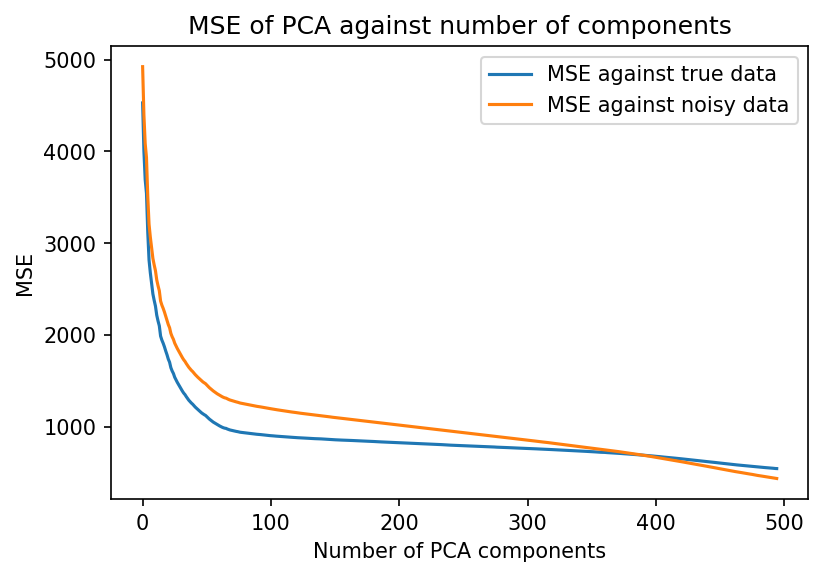

In [49]:
plt.figure(dpi=150)
plt.title("MSE of ")
plt.title("MSE of PCA against number of components")
plt.plot(testmse124, label="MSE against true data")
plt.plot(testmse124noisy, label="MSE against noisy data")
plt.xlabel('Number of PCA components')
plt.ylabel("MSE")
plt.legend()
plt.show()

We can see that initially, as $m$ increases, the MSE against the noisy data is higher than the MSE against the true data, indicating that our PCA is succesfully reducing the noise.

However, around $m=400$ principle components, the lines intersect, and the MSE on the true data becomes higher. This is because we have enough principle components to allow the noise to be captured in the rank-reduced X, and so our PCA becomes useless.

Clearly, an optimal $m$ is one much less than 400.

We will visualise an image below and see that, as the number of PCA components increases, to a point, clarity is increased, however after around 100, the clarity remains the same however background noise is picked up on.

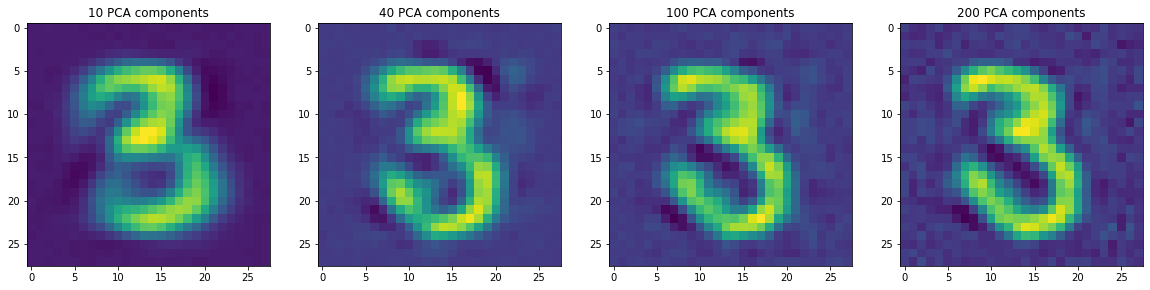

In [50]:
np.random.seed(67)

m_range = [10, 40, 100, 200]

sample_selection = np.random.randint(x1_test.shape[0])

fig, axs = plt.subplots(nrows=1, ncols=len(m_range),figsize=(20,5))
for i, m in enumerate(m_range):
    x124 = unstandardise(standardise(x12_test, x12_train) @ eigenvectors124[:,:m] @ eigenvectors124[:,:m].T, x12_train)
    axs[i].imshow(x124[sample_selection].reshape([28,28]))
    axs[i].set_title(f"{m} PCA components")

#### 1.3 Gaussian Mixture Models (20 marks)
1.3.1


We start with the definition of a Gaussian Mixture Model (GMM):
$$
P(\boldsymbol{X}=\boldsymbol{x}) = \sum_{k=1}^K \pi_k p_k(\boldsymbol{x}|\boldsymbol{\theta})\, .
$$
Here $K$ is the number of clusters described as mixture components, each of which are multivariate normal distributions:
$$
p_k(\boldsymbol{x}|\boldsymbol{\theta}) = {\displaystyle (2\pi )^{-k/2}\det({\boldsymbol {\Sigma }_k})^{-1/2}\,\exp \left(-{\frac {1}{2}}(\mathbf {x} -{\boldsymbol {\mu }_k})^{\!{\mathsf {T}}}{\boldsymbol {\Sigma }_k}^{-1}(\mathbf {x} -{\boldsymbol {\mu }_k})\right),}
$$
where $\boldsymbol{\theta} = \{\pi_k,\mu_k, \Sigma_k \}_{k=1,2,...,K}$ is the vectors of parameters consiting of the mixture weight $\pi_k$, mixture component mean $\boldsymbol{\mu}_k$ and mixture component covariance matrix $\boldsymbol{\mu}_k$.

In [51]:
from scipy.stats import multivariate_normal 

class GMModel:
    """Struct to define Gaussian Mixture Model"""
    """:param dim: number of mixture components"""
    """:param weights: mixture weights"""
    """:param mu: mixture component means for each cluster"""
    """:param sigma: mixture component covariance matrix for each cluster"""
    
    def __init__(self, X, dim):
        """Initialises parameters through random split of the data"""
        
        self.dim = dim

        # initial weights given to each cluster are stored in phi or P(Ci=j)
        self.phi = np.full(shape=self.dim, fill_value=1/self.dim) 

        # initial weights given to each data point wrt to each cluster or P(Xi/Ci=j)
        self.weights = np.full(shape=X.shape, fill_value=1/self.dim)
        
        n,m = X.shape 
        # dataset is divided randomly into k parts of unequal sizes
        random_row = np.random.randint(low=0, high=n, size=self.dim)

        # initial value of mean of k Gaussians
        self.mu = [  X[row_index,:] for row_index in random_row ]  

        # initial value of covariance matrix of k Gaussians
        self.sigma = [ np.cov(X.T) for _ in range(self.dim) ] 

def cluster_probabilities(gmm, X):
    """Predicts probability of each data point with respect to each cluster"""
    
    # n has the number of rows while m has the number of columns of dataset X
    n,m = X.shape 
    # Creates a n*k matrix denoting likelihood belonging to each cluster 
    likelihood = np.zeros( (n, gmm.dim) ) 
    for i in range(gmm.dim):
        # likelihood of data belonging to i-th cluster 
        distribution = multivariate_normal(mean=gmm.mu[i],cov=gmm.sigma[i]) ### <- fill in
        likelihood[:,i] = distribution.pdf(X) 

        numerator = likelihood * gmm.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
    return weights

def predict(gmm, X):
    """Performs hard clustering"""
    weights = cluster_probabilities(gmm,X)
    return np.argmax(weights, axis=1)

We can perform 'soft' clustering of the data using the cluster probabilities of the data:
$$r_{ik}(\boldsymbol{\theta})=P(Z=k|\boldsymbol{X}=\boldsymbol{x}_i,\boldsymbol{\theta}) = \frac{\pi_k p_k(\boldsymbol{x}_i|\boldsymbol{\theta})}{\sum_{k'=1}^K \pi_{k'} p_{k'}(\boldsymbol{x}_i|\boldsymbol{\theta})}$$
This denotes the probability of data point $i$ to belong to cluster $k$.

In [52]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = predict(gmm,X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights.max()
    #for pos, covar, w in zip(gmm.mu, gmm.sigma, gmm.phi):
        #draw_ellipse(pos, covar, alpha=w * w_factor)
    return ax

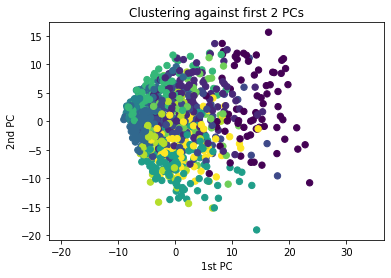

In [56]:
X_GMM, _, _ = pca_function(x12_train_standardised, 5)
X_GMM = X_GMM[:1000, :]

true_GMM = y1_train[:1000]

gmm = GMModel(X_GMM, 10)
plot_gmm(gmm,X_GMM)
plt.xlabel("1st PC");
plt.ylabel("2nd PC");
plt.title("Clustering against first 2 PCs");

The clusters seem pretty random, though the first two principle components do separate them a bit. We will now train the GMM with the EM algorithm:

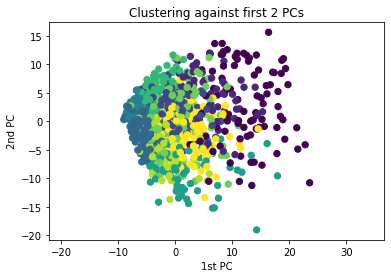

In [57]:
def fitStep(gmm,X):
    """Performs an EM step by updating all parameters"""
    
    # E-Step: update weights and phi holding mu and sigma constant
    weights = cluster_probabilities(gmm,X) ### <- fill in
    gmm.phi = weights.mean(axis=0)
        
    # M-Step: update mu and sigma holding pi and weights constant
    for i in range(gmm.dim):
        weight = weights[:, [i]]
        total_weight = weight.sum()

        gmm.mu[i] = (X * weight).sum(axis=0) / total_weight 
        gmm.sigma[i] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True)

for _ in range(10000):
    fitStep(gmm,X_GMM)

plot_gmm(gmm,X_GMM)
plt.xlabel("1st PC");
plt.ylabel("2nd PC");
plt.title("Clustering against first 2 PCs");

We see slightly more clustering on the right hand side. We will now plot the labels of each datum against the top 2 principle components:

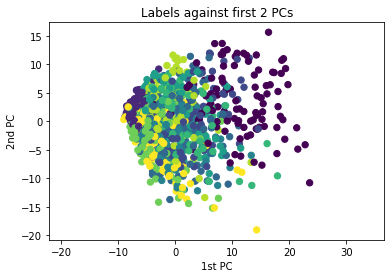

In [58]:
def plot_gmm_class_labels(gmm, X, y_true, ax=None):
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y_true, s=40, cmap='viridis', zorder=2)

    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights.max()
    #for pos, covar, w in zip(gmm.mu, gmm.sigma, gmm.phi):
        #draw_ellipse(pos, covar, alpha=w * w_factor)
    return ax

plot_gmm_class_labels(gmm, X_GMM, true_GMM)
plt.xlabel("1st PC");
plt.ylabel("2nd PC");
plt.title("Labels against first 2 PCs");

We can see that some labels are somewhat associated to each cluster. We will now define two label-cluster maps: the first based on the most frequent cluster containing data of that label, and the second based on maximising the log likelihood of the cluster.

In [59]:
def map_labels_to_clusters(X, y, gmm):
    labels = predict(gmm, X)
    
    # Find the cluster index that best matches each class label
    cluster_indices = {}
    for label in np.unique(y):
        mask = (y == label)
        cluster = np.bincount(labels[mask]).argmax()
        cluster_indices[label] = cluster
    
    print("Mapping of class labels to GMM cluster indices:")
    print(cluster_indices)
    
    return labels

labels_pred_GMM = map_labels_to_clusters(X_GMM, true_GMM, gmm)

Mapping of class labels to GMM cluster indices:
{0: 0, 1: 4, 2: 9, 3: 7, 4: 3, 5: 6, 6: 2, 7: 3, 8: 6, 9: 3}


In [60]:
from scipy.stats import multivariate_normal

def log_likelihood_gmm(X, Y, gmm):
    """
    Evaluates the log-likelihood of each GMM component at the data in each class.

    Parameters:
    X (numpy array): The input data, where each row represents a sample and each column represents a feature.
    Y (numpy array): The class labels for the input data.
    gmm : A trained GMM model.

    Returns:
    log_likelihood (numpy array): A 2D array where the (i,j)th element represents the log-likelihood of the jth GMM component
        evaluated at the data in the ith class.
    """

    num_classes = len(np.unique(Y))
    num_components = gmm.dim

    log_likelihood = np.zeros((num_classes, num_components))

    for i in range(num_classes):
        class_features = X[Y == i]
        for j in range(num_components):
            log_likelihood[i,j] = np.mean(np.log(np.sum(gmm.phi[j] * multivariate_normal.pdf(class_features, mean=gmm.mu[j], cov=gmm.sigma[j]))))

    return log_likelihood


In [61]:
log_likelihoods = log_likelihood_gmm(X_GMM, true_GMM, gmm)
label_preds_LL = dict(zip(list(range(10)), np.argmax(log_likelihoods, axis=1)))
label_preds_LL

{0: 6, 1: 4, 2: 9, 3: 7, 4: 3, 5: 6, 6: 6, 7: 3, 8: 6, 9: 3}

We see that the two labelling methods largely coincide. We will now visualise the log-likelihood (under softmax, a monotonic increasing transformation for clarity of the plot):

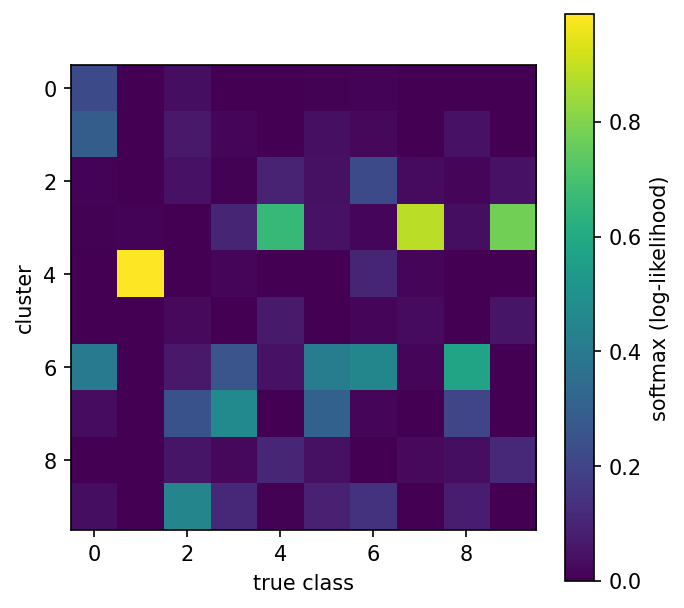

In [62]:
plt.figure(figsize=(5,5), dpi=150)
plt.imshow(stable_softmax(log_likelihoods).T)
plt.xlabel("true class")
plt.ylabel("cluster")
plt.colorbar(label="softmax (log-likelihood)")
plt.show()

We see that, when the true digit is a 1 or 7, the model is fairly certain which cluster it belongs in. 4, 7 and 9 are all mapped to cluster 3, which makes sense seeing as they look reasonably indistinguishable, as are 3 and 8.

1.3.3

We will now plot, for the images in each class, the values on the first two principle components colored by their log-likelihood of belonging to the most likely cluster.

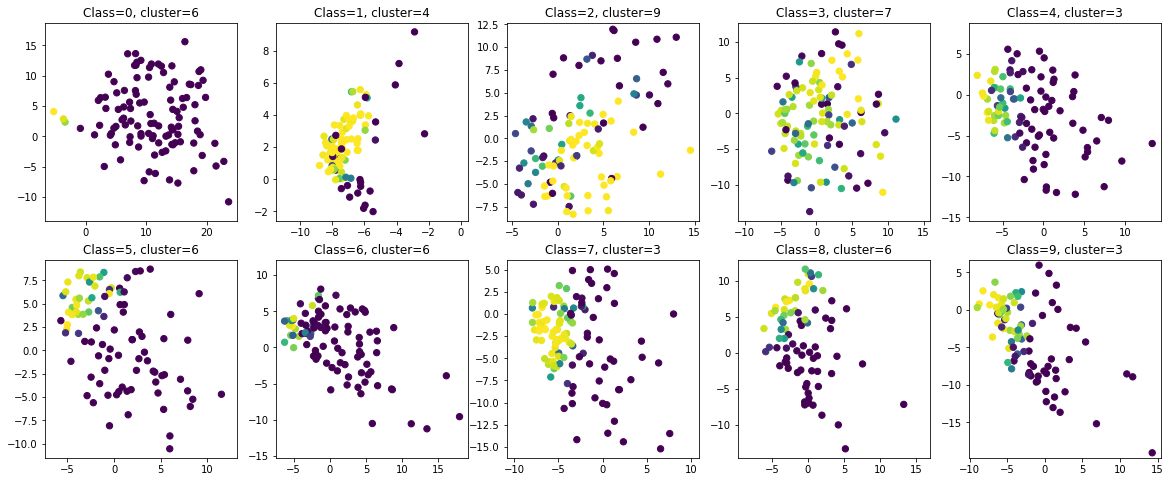

In [63]:
cluster_prob = []
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20,8))
for label, ax in enumerate(axs.reshape(-1)):
    X_label = X_GMM[true_GMM == label]
    MLE_cluster = label_preds_LL[label]
    max_cluster_prob = cluster_probabilities(gmm, X_label)[:, MLE_cluster]
    ax.scatter(X_label[:, 0], X_label[:, 1], c=max_cluster_prob, s=40, cmap='viridis', zorder=2)
    ax.axis('equal')
    ax.set_title(f"Class={label}, cluster={label_preds_LL[label]}")


We see that in a lot of cases, the GMM is reasonably unsure about the log-likelihood of each point belonging to each cluster. The first two principle components capture a reasonably large amount of the variance - meaning that the clusters appear geometrically distinct when projected onto these components. The shapes of each class when assigned the same cluster also seem reasonably similar - this is a likely explanation for why, for example, 4 and 9 are both mapped to the same cluster.

In [64]:
gmm5 = GMModel(X_GMM, 5)
gmm8 = GMModel(X_GMM, 8)

for _ in range(10000):
    fitStep(gmm5, X_GMM)
    fitStep(gmm8, X_GMM)

In [65]:
log_likelihoods5 = log_likelihood_gmm(X_GMM, true_GMM, gmm5)
label_preds_LL5 = dict(zip(list(range(10)), np.argmax(log_likelihoods5, axis=1)))
label_preds_LL5

{0: 2, 1: 4, 2: 3, 3: 3, 4: 2, 5: 2, 6: 3, 7: 2, 8: 2, 9: 2}

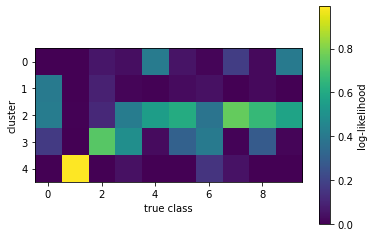

In [66]:
plt.imshow(stable_softmax(log_likelihoods5).T)
plt.xlabel("true class")
plt.ylabel("cluster")
plt.colorbar(label="log-likelihood")
plt.show()

We see that, when the number of principle components is reduced to 5, the clustering is a lot poorer at capturing the different classes - it seems like a lot of the images seem to be mapped to cluster 3. In fact, when we observe the unique clusters that images are mapped to, we see that it's only 3 of the 5.

In [67]:
print(np.unique(list(label_preds_LL5.values())))

[2 3 4]


In [68]:
log_likelihoods8 = log_likelihood_gmm(X_GMM, true_GMM, gmm8)
label_preds_LL8 = dict(zip(list(range(10)), np.argmax(log_likelihoods8, axis=1)))
label_preds_LL8

{0: 1, 1: 6, 2: 5, 3: 7, 4: 4, 5: 7, 6: 1, 7: 4, 8: 7, 9: 4}

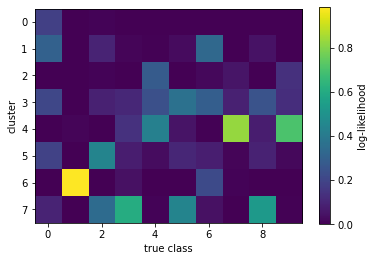

In [69]:
plt.imshow(stable_softmax(log_likelihoods8).T)
plt.xlabel("true class")
plt.ylabel("cluster")
plt.colorbar(label="log-likelihood")
plt.show()

This is slightly better, however we still see a lot of overlap in the images, with similar digits being mapped to the same cluster. Generally, it seems that more clusters will more effectively separate the tumours into their distinct types.

#### 2.1 Clustering (15 marks)
2.1.1

We begin by loading the second dataset.

In [70]:
data2 = pd.read_csv('gene_expression_data.csv')
data2.head()

Gene 0    Gene 1    Gene 2    Gene 3     Gene 4     Gene 5     Gene 6  \
0   9.796088  0.591871  0.591871  0.000000  11.420571  13.453759   4.411847   
1  10.070470  0.000000  0.000000  0.000000  13.085672  14.531863  10.462298   
2   8.970920  0.000000  0.452595  0.000000   8.263119   9.754908   8.964549   
3   8.524616  1.039419  0.434882  0.000000  10.798520  12.263020   7.440695   
4   8.047238  0.000000  0.000000  0.360982  12.283010  14.033759   8.719180   

     Gene 7     Gene 8     Gene 9  ...   Gene 86   Gene 87    Gene 88  \
0  5.412334  10.771613  10.225665  ...  5.974369  8.086513  12.727750   
1  9.832926  13.520312  13.968046  ...  0.000000  0.000000  11.197204   
2  9.948113   8.693773   8.776111  ...  3.907160  5.324101  11.487066   
3  8.062343   8.802083   9.237487  ...  4.296083  6.959747  12.974639   
4  8.831472   8.462073   8.211202  ...  0.000000  0.000000  11.337237   

     Gene 89    Gene 90    Gene 91   Gene 92    Gene 93    Gene 94  Type  
0  15.205717   6.438116   6.412577  0.000000   6.814730  13.618145  PRAD  
1  12.993933  10.800746  10.749811  0.000000  11.445610   0.000000  LUAD  
2  13.380596   6.656236  10.209734  0.000000   7.748830  12.759976  PRAD  
3  14.891812   6.030725   7.315648  0.434882   7.117924  12.353276  PRAD  
4  13.390061   5.989593   8.359671  0.000000   6.327545   0.000000  BRCA  

[5 rows x 96 columns]

We will now separate our dataset into gene expression, and the type of tumour (predictors and labels).

In [71]:
type = data2["Type"].to_numpy(dtype=str)
genes = data2.drop("Type", axis=1).to_numpy(dtype=float)

n_samples, n_features = genes.shape

We wish to implement $k$-means with a $k$ that optimises the CH index. We will write a function to calculate the CH index of a given clustering:

$$CH_k = \frac{BCSM}{k-1} \frac{n-k}{WCSM}$$

In [72]:
def bcsm(X, centroids, labels, k):
    bcsm = 0
    for i in np.arange(k):
        ni = sum(labels==i)
        zi = centroids[i]
        ztot = np.mean(X, axis=0)
        bcsm += np.linalg.norm(zi - ztot) ** 2 * ni
    return bcsm

def wcsm(X, centroids, labels, k):
    wcsm = 0
    for i in np.arange(k):
        xi = X[labels==i]
        zi = centroids[i]
        for xx in xi:
            wcsm += np.linalg.norm(xx - zi) ** 2
    return wcsm

def CH_index(X, centroids, labels, k):
    if wcsm:
        return (bcsm(X, centroids, labels, k) / (k - 1)) * (X.shape[0] - k) / wcsm(X, centroids, labels, k)
    return np.inf


We now write a function to perform the $k$-means algorithm given in the notes:

In [73]:
def kmeans_pass(X, k):

    n_samples, n_features = X.shape
    labels = np.random.randint(low=0, high=k, size=n_samples)
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)

    # computing the centroids of each of the k clusters
    centroids = np.zeros((k, n_features))
    for i in np.arange(k):
        if (len([x for x in X_labels if x[-1] == i]) == 0):
            continue
        else:
            centroids[i] = np.mean([x for x in X_labels if x[-1]==i], axis=0)[0:n_features]

    max_iter = 80
    new_labels = np.zeros(len(X))
    difference = 0

    # k-means algorithm
    for i in np.arange(max_iter):
        #print('Iteration:', i)
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)

        if (labels==new_labels).all():
            # labels unchanged
            labels = new_labels
            #print('Labels unchanged! Terminating k-means.')
            break
        else:
            # labels changed
            # difference: percentage of changed labels
            difference = np.mean(labels!=new_labels) 
            #print('%4f%% labels changed' % (difference * 100))
            labels = new_labels
            for c in np.arange(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X[labels==c], axis=0)
    return labels, centroids

We will now train our $k$-means clusterer on the dataset, optimising $CH_k$ over a range from 1 to 10.

In [74]:
np.random.seed(123)

num_starts = 5
max_k = 10
CH_list = []

for k in np.arange(1, max_k):
    print (f"Training for k={k}")
    CH_this_iter = []
    for _ in np.arange(num_starts):
        labels, centroids = kmeans_pass(genes, k)
        CH_this_iter.append(CH_index(genes, centroids, labels, k))
    CH_list.append(np.average(CH_this_iter))

Training for k=1
Training for k=2
Training for k=3


<ipython-input-72-1358c787b012>:21: RuntimeWarning: divide by zero encountered in double_scalars
  return (bcsm(X, centroids, labels, k) / (k - 1)) * (X.shape[0] - k) / wcsm(X, centroids, labels, k)


Training for k=4
Training for k=5
Training for k=6
Training for k=7
Training for k=8
Training for k=9


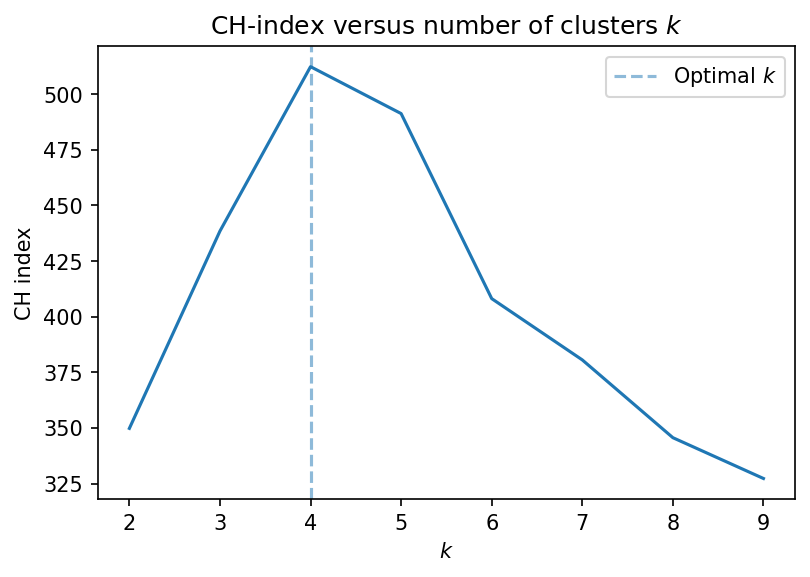

In [75]:
plt.figure(dpi=150)
plt.title("CH-index versus number of clusters $k$")
plt.xlabel("$k$")
plt.ylabel("CH index")
plt.axvline(4, label="Optimal $k$", linestyle="--", alpha=0.5)
plt.plot(np.arange(1, max_k), CH_list)
plt.legend()
plt.show()

We see that the optimal $k$ is 4. We will now observe the cluster sizes at this value of $k$.

In [76]:
k = 4
labels, centroids = kmeans_pass(genes, 4)
clustersizes = {i: sum(labels==i) for i in range(k)}
print (f"cluster sizes: {clustersizes}")

cluster sizes: {0: 143, 1: 122, 2: 400, 3: 135}


2.1.2
We see that one of the clusters is much larger, and the others are similar sizes; we will now assess how the clustering coincides with the true labels, with the homogeneity score:

$$1 - \frac{H(C|K)}{H(C)}$$

In [77]:
def homogeneity_score(labs, typs):

    N = len(labs)
    types_unique = list(set(typs)) #list of class labels
    labels_unique = list(set(labs))
    h_ck = 0
    h_c = 0
    for k in labels_unique:
        abs_k = sum(labs == k)
        for c in types_unique:
            a_ck = sum(np.logical_and(labs == k, typs == c))
            if a_ck:
                h_ck -= (a_ck / N) * np.log(a_ck / abs_k)
    for c in types_unique:
        abs_c = sum(typs == c)
        h_c -= (abs_c / N) * np.log(abs_c / N)
    
    return 1 - h_ck / h_c

            
print (f'homogeneity score: {homogeneity_score(labels, type):.3f}')


homogeneity score: 0.665


The homogeneity score is around 66%, suggesting that the labels and clusters coincide more often than not. This is indicative of the fact that individual gene expression has something to do with the classification of the tumour.

2.2.1

We will now consider the adjacency matrix $A$ based on the matrix of correlations of gene co-expression, filtered on those whose absolute value is greater that 0.75. We will visualise this matrix with `imshow`:

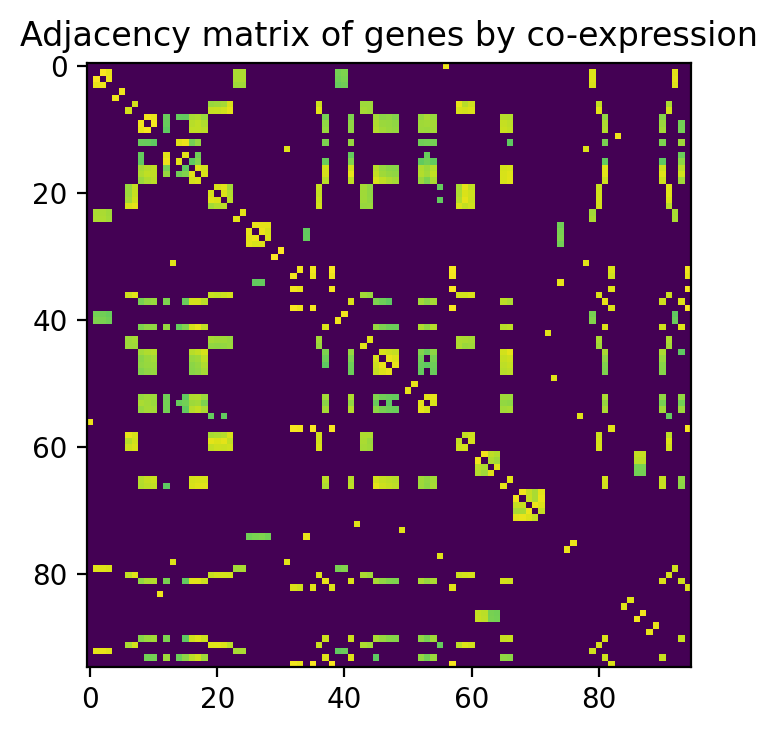

In [78]:
plt.figure(dpi=200)
A221 = np.corrcoef(genes, rowvar=False)
A221[np.abs(A221) <= 0.75] = 0
np.fill_diagonal(A221, 0)
plt.title('Adjacency matrix of genes by co-expression')
plt.imshow(A221)
plt.show()

The matrix is reasonably sparse, suggesting that many of the genes are uncorrelated. We will attempt to group co-expressed genes with spectral partitioning:

2.2.2

In [79]:
weighted_degree = A221.sum(axis=1) 
D221 = np.diag(weighted_degree)
degree_sorted = np.flip(np.argsort(weighted_degree))
print(f"Indices of 5 top ranking genes: {degree_sorted[:5]}")

Indices of 5 top ranking genes: [17 41 16 81 90]


The indices of the 5 top-ranking genes provide those which have the highest degree, i.e which exhibit co-expression most strongly with many other genes. It is observable that in the graph of adjacency, these indices do indeed show high co-expression.

We will now find the normalised Laplacian, and its eigenvectors and eigenvalues, to identify a spectral partition.

In [80]:
weighted_degree_sqrt = 1.0 / np.sqrt(weighted_degree)
D_inv_sqrt = np.diag(weighted_degree_sqrt)

from scipy.sparse import linalg

# define the normalised Laplacian
L223_norm = np.eye(A221.shape[0]) - D_inv_sqrt.dot(A221.dot(D_inv_sqrt))
eigenvals223, eigenvecs223 = linalg.eigsh(L223_norm, 95, which="SM", return_eigenvectors=True)


/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1590: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


In [81]:
zeroeigs = sum(eigenvals223 < 1e-13)
print(f"There are r={zeroeigs} zero eigenvalues")

There are r=18 zero eigenvalues


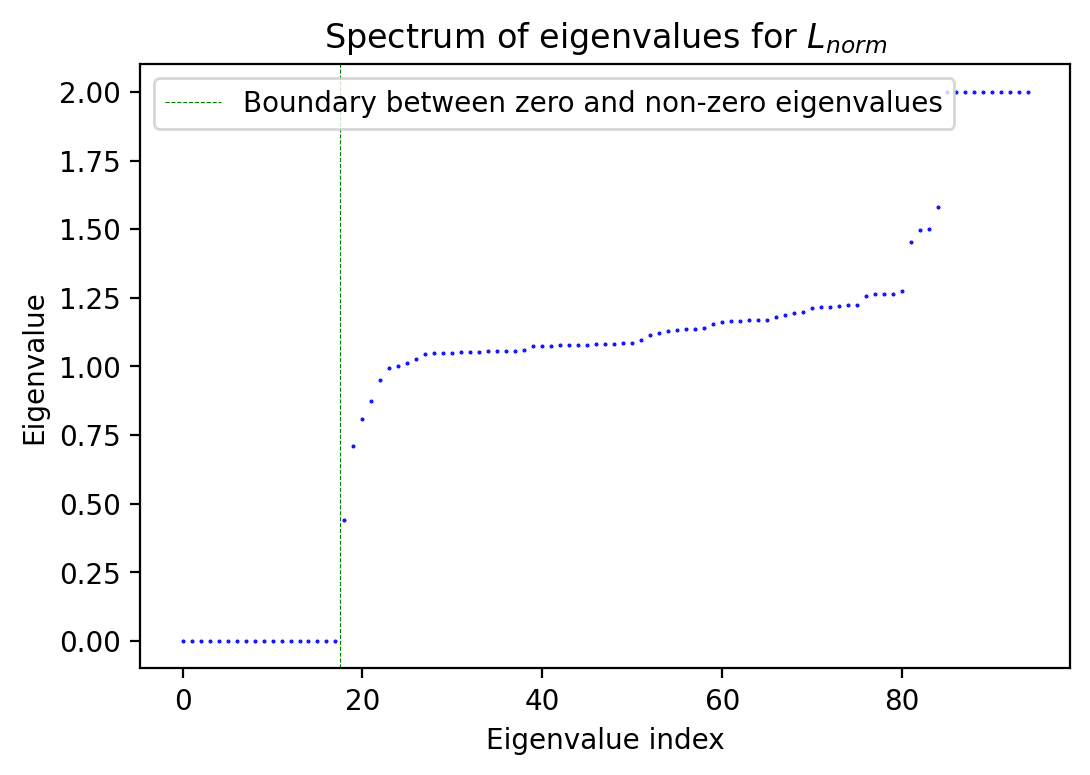

In [82]:
plt.figure(dpi=200)
plt.scatter(np.arange(len(eigenvals223)), eigenvals223, s=0.2, color='b')
plt.title("Spectrum of eigenvalues for $L_{norm}$")
plt.xlabel("Eigenvalue index")
plt.ylabel("Eigenvalue")
plt.axvline(zeroeigs - 0.5, linestyle="--", lw=0.4, color='g', label="Boundary between zero and non-zero eigenvalues")
plt.legend()
plt.show()

We see 18 zero eigenvalues, meaning we have 18 connected components of the graph represented by $A$. Therefore, when we perform $k$-means clustering, we would expect $k=18$ to give a good clustering, effectively separating the connected components.

In [113]:
U224 = eigenvecs223[:, :zeroeigs]
T224 = (U224 / np.linalg.norm(U224, axis=0))

In [114]:
def within_cluster_distance_norm(X, labels, k):
    output = 0
    for i in np.arange(k):
        x_c = X[labels==i]
        c_l = x_c.shape[0]
        thisiter_output = 0
        for i, xi in enumerate(x_c[:-1]):
            for j, xj in enumerate(x_c[i + 1:]):
                thisiter_output += np.linalg.norm(xi - xj) ** 2
        if c_l:
            thisiter_output /= c_l
        output += thisiter_output
    return output / 2

score224 = []
for k in np.arange(1, 60):
    this_score = []
    for _ in np.arange(5):
        labels224, _ = kmeans_pass(T224, k)
        this_score.append(within_cluster_distance_norm(T224, labels224, k))
    score224.append(sum(this_score) / 5)


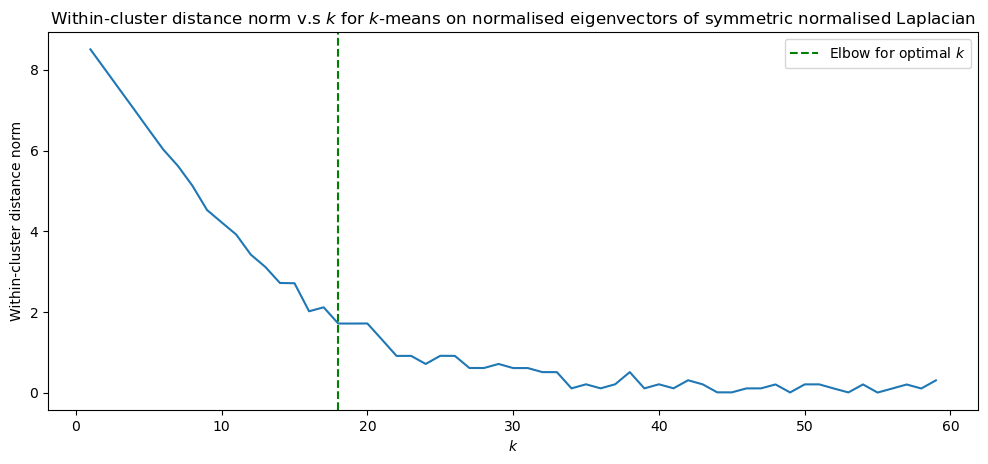

In [115]:
plt.figure(figsize=(12,5), dpi=100)
plt.title("Within-cluster distance norm v.s $k$ for $k$-means on normalised eigenvectors of symmetric normalised Laplacian")
plt.plot(np.arange(1, 60), score224)
plt.axvline(18, label="Elbow for optimal $k$", linestyle="--", color="g")
plt.xlabel("$k$")
plt.ylabel("Within-cluster distance norm")
plt.legend()
plt.show()

Whilst the exact location of the elbow is unclear, it seems our suspicions were correct: $k=18$ provides a good choice for the optimal $k$. We will therefore fix this and proceed to partition the largest cluster.

In [116]:
k = 18
labels224, centroids = kmeans_pass(T224, k)
clusters225 = [sum(labels224 == i) for i in range(k)]
print (f"cluster sizes: {clusters225}")

cluster sizes: [3, 2, 6, 2, 0, 14, 5, 9, 2, 2, 2, 4, 9, 8, 0, 23, 2, 2]


There is a very clear largest cluster, along with several smaller ones. Let's inspect the adjacency matrix of the largest cluster:

2.2.5

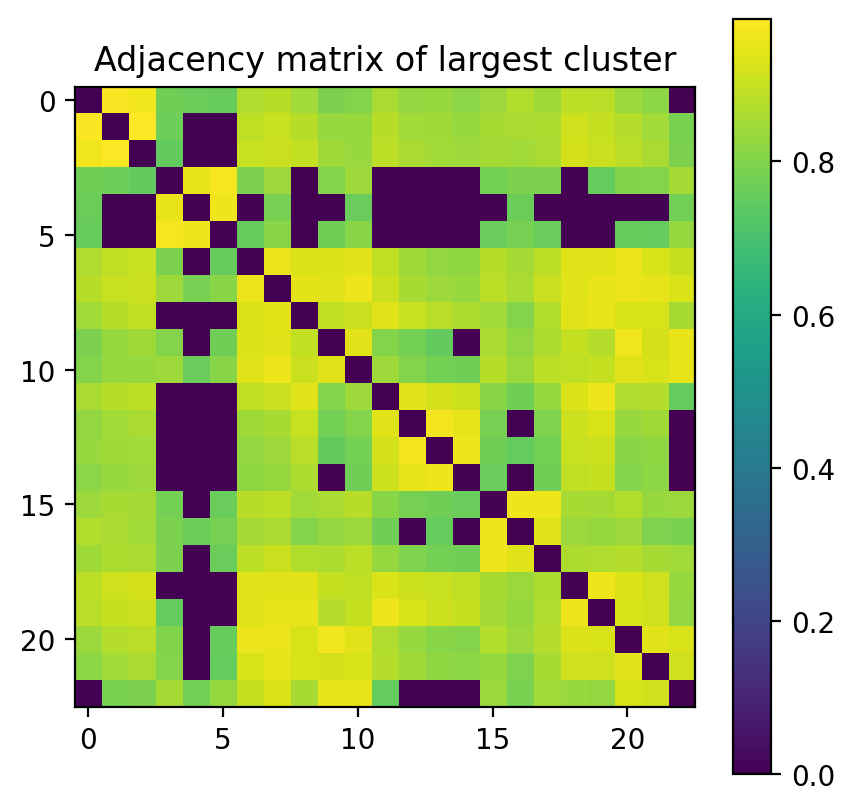

In [117]:
largestclusterindex = np.argmax(clusters225)
labels224 == largestclusterindex
subgraph = A221[labels224 == largestclusterindex][:,labels224 == largestclusterindex]
plt.figure(dpi=200, figsize=(5,5))
plt.imshow(subgraph)
plt.title("Adjacency matrix of largest cluster")
plt.colorbar()
plt.show()

The adjacency matrix is much less sparse, showing that our clustering has effectively grouped genes which are co-expressed: however, there still appears to be an index which shows little correlation with other genes. With spectral partitioning, we hope to disconnect the graph around this index to end up with two connected subgraphs.

In [118]:
weighted_degree1 = subgraph.sum(axis=1)
weighted_degree_sqrt1 = 1.0/np.sqrt(weighted_degree1)
D_inv_sqrt1 = np.diag(weighted_degree_sqrt1)
L_norm1 = np.eye(subgraph.shape[0]) - D_inv_sqrt1.dot(subgraph.dot(D_inv_sqrt1))

eigenvals225, eigenvecs225 = linalg.eigsh(L_norm1, 22, which="SM", return_eigenvectors=True)

second_eigenvector = eigenvecs225[:,1]
spectral_partition = second_eigenvector
spectral_partition[spectral_partition<0] = 0
spectral_partition[spectral_partition>0] = 1
subgraph.shape

(23, 23)

In [119]:
eigenvals225

array([1.60688634e-17, 7.09824816e-01, 9.49448789e-01, 9.93084679e-01,
       1.00281813e+00, 1.01076222e+00, 1.02782108e+00, 1.04465433e+00,
       1.04783531e+00, 1.04956517e+00, 1.05073999e+00, 1.05162853e+00,
       1.05387651e+00, 1.05532375e+00, 1.05570299e+00, 1.05633592e+00,
       1.05665956e+00, 1.08600827e+00, 1.09526489e+00, 1.11444086e+00,
       1.12087585e+00, 1.15353425e+00])

In [120]:
spectral_partition

array([1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1.])

Text(0.5, 1.0, 'Subgraph 1')

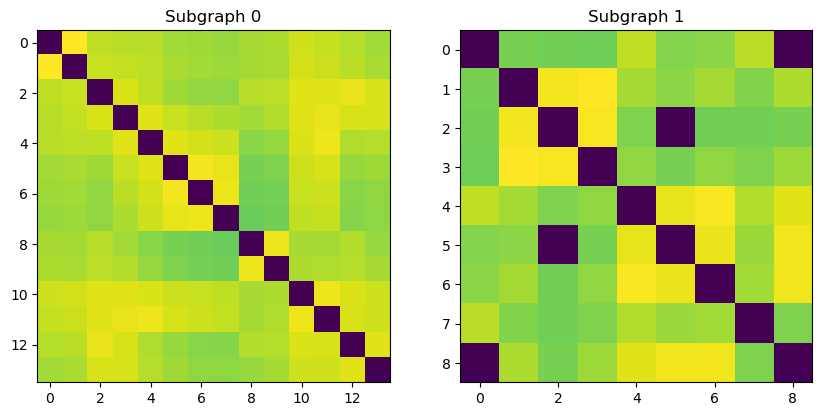

In [121]:
subgraph0 = subgraph[spectral_partition == 0][:,spectral_partition == 0]

subgraph1 = subgraph[spectral_partition == 1][:, spectral_partition == 1]


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,6), dpi=100)
axs[0].imshow(subgraph0)
axs[0].set_title("Subgraph 0")
axs[1].imshow(subgraph1)
axs[1].set_title("Subgraph 1")

The subgraphs generated through spectral partitioning have succsfully isolated co-expressed genes: to the point that, in fact, the larger subgraph is completely connected. It seems we have succesfully identified two groups of genes which are co-expressed. We will observe the network links <b>across</b> the two partitions:

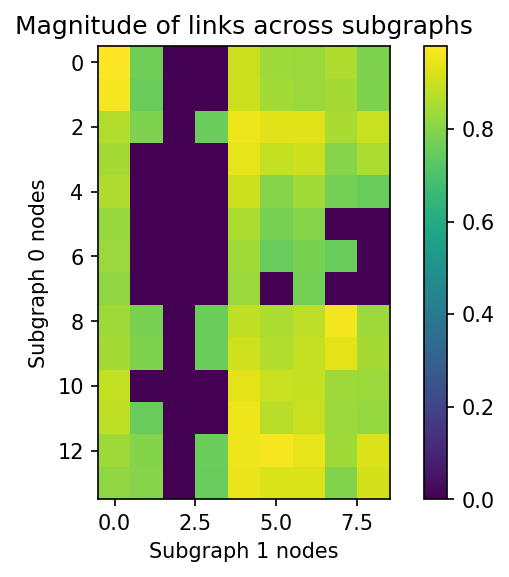

In [122]:
across225 = subgraph[spectral_partition == 0][:, spectral_partition == 1]
plt.figure(dpi=150)
plt.title("Magnitude of links across subgraphs")
plt.ylabel('Subgraph 0 nodes')
plt.xlabel('Subgraph 1 nodes')
plt.imshow(across225)
plt.colorbar()
plt.show()

We see a large number of nodes with 0 connection betweeen them - this indicates that our spectral partition has optimised the loss function well, as these 'connections' are cut to make the subgraphs.

2.2.6

We will compute the degree centrality of the subgraph corresponding to the largest cluster:

In [123]:
weighted_degree226 = subgraph.sum(axis=1) 
D226 = np.diag(weighted_degree226)
degree_sorted226 = np.flip(np.argsort(weighted_degree226))
print(f"Indices of 5 top ranking genes of subgraph: {degree_sorted226[:5]}")
print(f"Indices of 5 top ranking genes of original: {degree_sorted[:5]}")

Indices of 5 top ranking genes of subgraph: [ 7 10  6 20 21]
Indices of 5 top ranking genes of original: [17 41 16 81 90]


Whilst these values are different, this is because we have selected a subset of the original graph, which distorts the indices. If we observe the actual corresponding values of weighted degree centrality, we see they coincide:

In [124]:
print (weighted_degree226[degree_sorted226[:5]])
print (weighted_degree[degree_sorted[:5]])

[19.73839866 19.04945567 18.64028395 18.53179044 18.2670517 ]
[19.73839866 19.04945567 18.64028395 18.53179044 18.2670517 ]


What does this tell us? The 5 largest nodes by degree centrality are the same, meaning that the subgraph has preserved these. Our largest subgraph obtained by $k$-means has grouped together the genes with the highest weighted degree centrality, i.e those which exhibit the most co-expression.